### Observed dryspells and correlation with forecasted dry spells in Malawi
This notebook explores the correlation of observed dry spells and the 15-day forecast provided by CHIRPS-GEFS. The goal of this analysis is to understand the performance of CHIRPS-GEFS for predicting dry spells in order to judge whether it is a suitable indicator to base anticipatory action for dry spells in Malawi on. 


The observed dry spells are computed in the R script `malawi/scripts/mwi_chirps_dry_spell_detection.R`. That script uses different methodologies to define a dry spell. This notebook assumes one is chosen, which is indicated by the filename of `dry_spells_list_path`
The CHIRPS-GEFS data is downloaded from [here](https://data.chc.ucsb.edu/products/EWX/data/forecasts/CHIRPS-GEFS_precip_v12/15day/Africa/precip_mean/) and processed in notebook `mwi_chirps_gefs.ipynb`. This notebook returns several statistics per ADMIN2 per forecast date from 2000 till 2020. 

The format CHIRPS-GEFS is produced is the 15 cumulative sum per raster cell. We take the mean of all the values within each admin2 in the `mwi_chirps_gefs.ipynb`. In this notebook several thresholds for this mean value are tested, as sometimes forecasts have the tendency to overestimate precipitation.

We are mainly focussing on the overlap between observed dry spell and forecasted dry spell. From the analysis you can see that this performance is already pretty bad. We shortly also explore a more strict definition where the start date of the observed dry spell has to be forecasted, but as could be expected this performance is even worse. 

Questions
- Is the processing of the data correct?
- Is any analysis missing?
- Is there a better way to visualize the results?
    - For the presentation I am planning to use the density polot of observations vs chirps-gefs, the heatmap, and some table showing precision/recall

Data limitations
- No CHIRPS-GEFS data is available from 01-01-2020 till 05-10-2020

Thoughts
- dry spell is at least 14 days while forecast 15 day cumulative sum --> might occur that 15 day sum is larger, but well from this analysis we see that even with higher threshold it is bad..

In [31]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import math 
from datetime import timedelta
import seaborn as sns
import calendar
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
import glob

In [33]:
from pathlib import Path
import sys
import os

path_mod = f"{Path(os.path.dirname(os.path.abspath(''))).parents[1]}/"
sys.path.append(path_mod)
from src.indicators.drought.config import Config

#### Set config values

In [34]:
country="malawi"
config=Config()
parameters = config.parameters(country)
country_iso3=parameters["iso3_code"]
data_public_dir = os.path.join(config.DATA_DIR,config.PUBLIC_DIR)
country_data_raw_dir = os.path.join(data_public_dir,config.RAW_DIR,country_iso3)
country_data_processed_dir = os.path.join(data_public_dir,config.PROCESSED_DIR,country_iso3)
country_data_exploration_dir = os.path.join(data_public_dir,"exploration",country_iso3)
dry_spells_processed_dir=os.path.join(country_data_processed_dir,"dry_spells")
chirpsgefs_processed_dir=os.path.join(country_data_processed_dir,"chirpsgefs")

#we have different methodologies of computing dryspells and rainy season
#this notebook chooses one, which is indicated by the files being used
chirpsgefs_stats_path=os.path.join(chirpsgefs_processed_dir,"mwi_chirpsgefs_rainyseas_stats_mean_back.csv")
rainy_season_path = os.path.join(dry_spells_processed_dir, "rainy_seasons_detail_2000_2020_mean_back.csv")
chirps_rolling_sum_path=os.path.join(dry_spells_processed_dir,"data_mean_values_long.csv")

adm2_bound_path=os.path.join(country_data_raw_dir,config.SHAPEFILE_DIR,parameters["path_admin2_shp"])

In [35]:
ds_meth="mean_2mm"
# ds_meth="consecutive_days_2mm"
# ds_meth="consecutive_days_4mm"

In [36]:
#we have different methodologies of computing dryspells and rainy season
#this notebook chooses one, which is indicated by the files being used
if ds_meth=="mean_2mm":
    dry_spells_list_path=os.path.join(dry_spells_processed_dir,f"dry_spells_during_rainy_season_list_2000_2020_mean_back.csv")
elif ds_meth=="consecutive_days_2mm":
    dry_spells_list_path=os.path.join(dry_spells_processed_dir,f"daily_mean_dry_spells_details_2mm_2000_2020.csv")
elif ds_meth=="consecutive_days_4mm":
    dry_spells_list_path=os.path.join(dry_spells_processed_dir,f"daily_mean_dry_spells_details_2000_2020.csv")

#### Load CHIRPS-GEFS data

In [39]:
all_files=glob.glob(os.path.join(chirpsgefs_processed_dir, "mwi_chirpsgefs_stats_*.csv"))

In [40]:
#combine files of all dates into one
#takes a minute
df_from_each_file = (pd.read_csv(f,parse_dates=["date"]) for f in all_files)
df_chirpsgefs_all = pd.concat(df_from_each_file, ignore_index=True)

In [86]:
#filter out dates that are outside the rainy season for each admin
onset_col="onset_date"
cessation_col="cessation_date"
rainy_adm_col="ADM2_EN"

df_rain = pd.read_csv(rainy_season_path, parse_dates=[onset_col, cessation_col])
 #remove entries where there is no onset and no cessation date, i.e. no rainy season
df_rain=df_rain[(df_rain.onset_date.notnull())|(df_rain.cessation_date.notnull())]
#if onset date or cessation date is missing, set it to Nov 1/Jul1 to make sure all data of that year is downloaded. This happens if e.g. the rainy season hasn't ended yet
df_rain[df_rain.onset_date.isnull()]=df_rain[df_rain.onset_date.isnull()].assign(onset_date=lambda df: pd.to_datetime(f"{df.season_approx.values[0]}-11-01"))
df_rain[df_rain.cessation_date.isnull()]=df_rain[df_rain.cessation_date.isnull()].assign(cessation_date=lambda df: pd.to_datetime(f"{df.season_approx.values[0]+1}-07-01"))

df_rain_adm = df_rain.groupby([rainy_adm_col, "season_approx"], as_index=False).agg({onset_col: np.min, cessation_col: np.max})
    
list_hist_rain_adm = []
for a in df_chirpsgefs_all[adm_col].unique():
    dates_adm = pd.Index([])
    df_rain_seladm = df_rain_adm[df_rain_adm[rainy_adm_col] == a]
    for i in df_rain_seladm.season_approx.unique():
        df_rain_seladm_seas = df_rain_seladm[df_rain_seladm.season_approx == i]
        seas_range = pd.date_range(df_rain_seladm_seas.onset_date.values[0],df_rain_seladm_seas.cessation_date.values[0])
        dates_adm = dates_adm.union(seas_range)
    list_hist_rain_adm.append(df_chirpsgefs[(df_chirpsgefs_all[adm_col] == a) & (df_chirpsgefs_all.date.isin(dates_adm))])
df_chirpsgefs = pd.concat(list_hist_rain_adm)

In [48]:
#when initial analysis was done, 12-03 was the last date, so selecting those to keep the numbers the same
df_chirpsgefs=df_chirpsgefs[df_chirpsgefs.date<="2021-03-12"]

In [43]:
# #ccontains several statistics per adm2-date combination since 2000
# df_chirpsgefs=pd.read_csv(chirpsgefs_stats_path)
# df_chirpsgefs["date"]=pd.to_datetime(df_chirpsgefs["date"])
# df_chirpsgefs["date_forec_end"]=pd.to_datetime(df_chirpsgefs["date_forec_end"])

In [44]:
df_chirpsgefs[(df_chirpsgefs.date=="2019-01-01")&(df_chirpsgefs.ADM2_EN=="Balaka")]

,Shape_Leng,Shape_Area,ADM2_EN,ADM2_PCODE,ADM2_REF,ADM2ALT1EN,ADM2ALT2EN,ADM1_EN,ADM1_PCODE,ADM0_EN,ADM0_PCODE,date,validOn,validTo,max_cell,min_cell,mean_cell,perc_se2,perc_se10,date_forec_end
2060,2.036817,0.179379,Balaka,MW312,NaN,NaN,NaN,Southern,MW3,Malawi,MW,2019-01-01,2018-10-16,NaN,157.190536,120.96553,137.260521,0.0,0.0,2019-01-15


In [45]:
len(df_chirpsgefs)

77184

In [29]:
df_chirpsgefs.tail()

,Shape_Leng,Shape_Area,ADM2_EN,ADM2_PCODE,ADM2_REF,ADM2ALT1EN,ADM2ALT2EN,ADM1_EN,ADM1_PCODE,ADM0_EN,ADM0_PCODE,date,validOn,validTo,max_cell,min_cell,mean_cell,perc_se2,perc_se10,date_forec_end
77179,0.295003,0.003375,Zomba City,MW314,NaN,NaN,NaN,Southern,MW3,Malawi,MW,2021-03-08,2018-10-16,NaN,174.211685,174.211685,174.211685,0.0,0.0,2021-03-22
77180,0.295003,0.003375,Zomba City,MW314,NaN,NaN,NaN,Southern,MW3,Malawi,MW,2021-03-09,2018-10-16,NaN,156.969940,156.969940,156.969940,0.0,0.0,2021-03-23
77181,0.295003,0.003375,Zomba City,MW314,NaN,NaN,NaN,Southern,MW3,Malawi,MW,2021-03-10,2018-10-16,NaN,143.903870,143.903870,143.903870,0.0,0.0,2021-03-24
77182,0.295003,0.003375,Zomba City,MW314,NaN,NaN,NaN,Southern,MW3,Malawi,MW,2021-03-11,2018-10-16,NaN,175.718323,175.718323,175.718323,0.0,0.0,2021-03-25
77183,0.295003,0.003375,Zomba City,MW314,NaN,NaN,NaN,Southern,MW3,Malawi,MW,2021-03-12,2018-10-16,NaN,249.067581,249.067581,249.067581,0.0,0.0,2021-03-26


In [20]:
df_chirpsgefs.head()

,Shape_Leng,Shape_Area,ADM2_EN,ADM2_PCODE,ADM2_REF,ADM2ALT1EN,ADM2ALT2EN,ADM1_EN,ADM1_PCODE,ADM0_EN,ADM0_PCODE,date,validOn,validTo,max_cell,min_cell,mean_cell,perc_se2,perc_se10,date_forec_end
0,2.036817,0.179379,Balaka,MW312,NaN,NaN,NaN,Southern,MW3,Malawi,MW,2000-01-01,2018-10-16,NaN,98.036362,62.076710,80.531206,0.0,0.0,2000-01-15
1,2.036817,0.179379,Balaka,MW312,NaN,NaN,NaN,Southern,MW3,Malawi,MW,2000-01-02,2018-10-16,NaN,162.112625,102.041756,129.338437,0.0,0.0,2000-01-16
2,2.036817,0.179379,Balaka,MW312,NaN,NaN,NaN,Southern,MW3,Malawi,MW,2000-01-03,2018-10-16,NaN,136.109085,78.451447,111.754927,0.0,0.0,2000-01-17
3,2.036817,0.179379,Balaka,MW312,NaN,NaN,NaN,Southern,MW3,Malawi,MW,2000-01-04,2018-10-16,NaN,142.170609,89.597649,119.948888,0.0,0.0,2000-01-18
4,2.036817,0.179379,Balaka,MW312,NaN,NaN,NaN,Southern,MW3,Malawi,MW,2000-01-05,2018-10-16,NaN,111.420197,83.012993,98.433085,0.0,0.0,2000-01-19


In [53]:
#included statistics in the file
cg_stats=["max_cell","mean_cell","min_cell","perc_se2","perc_se10"]

In [11]:
#less than num unique dates*adm2s cause most adm2s end their rainy season earlier (or start later) and thus those date-adm2 combinations are not included
len(df_chirpsgefs)

77184

In [49]:
len(df_chirpsgefs.date.unique())

3358

In [50]:
len(df_chirpsgefs.ADM2_EN.unique())

32

In [51]:
df_chirpsgefs.date.dt.month.unique()

array([ 1,  2,  3, 11, 12,  4,  5])

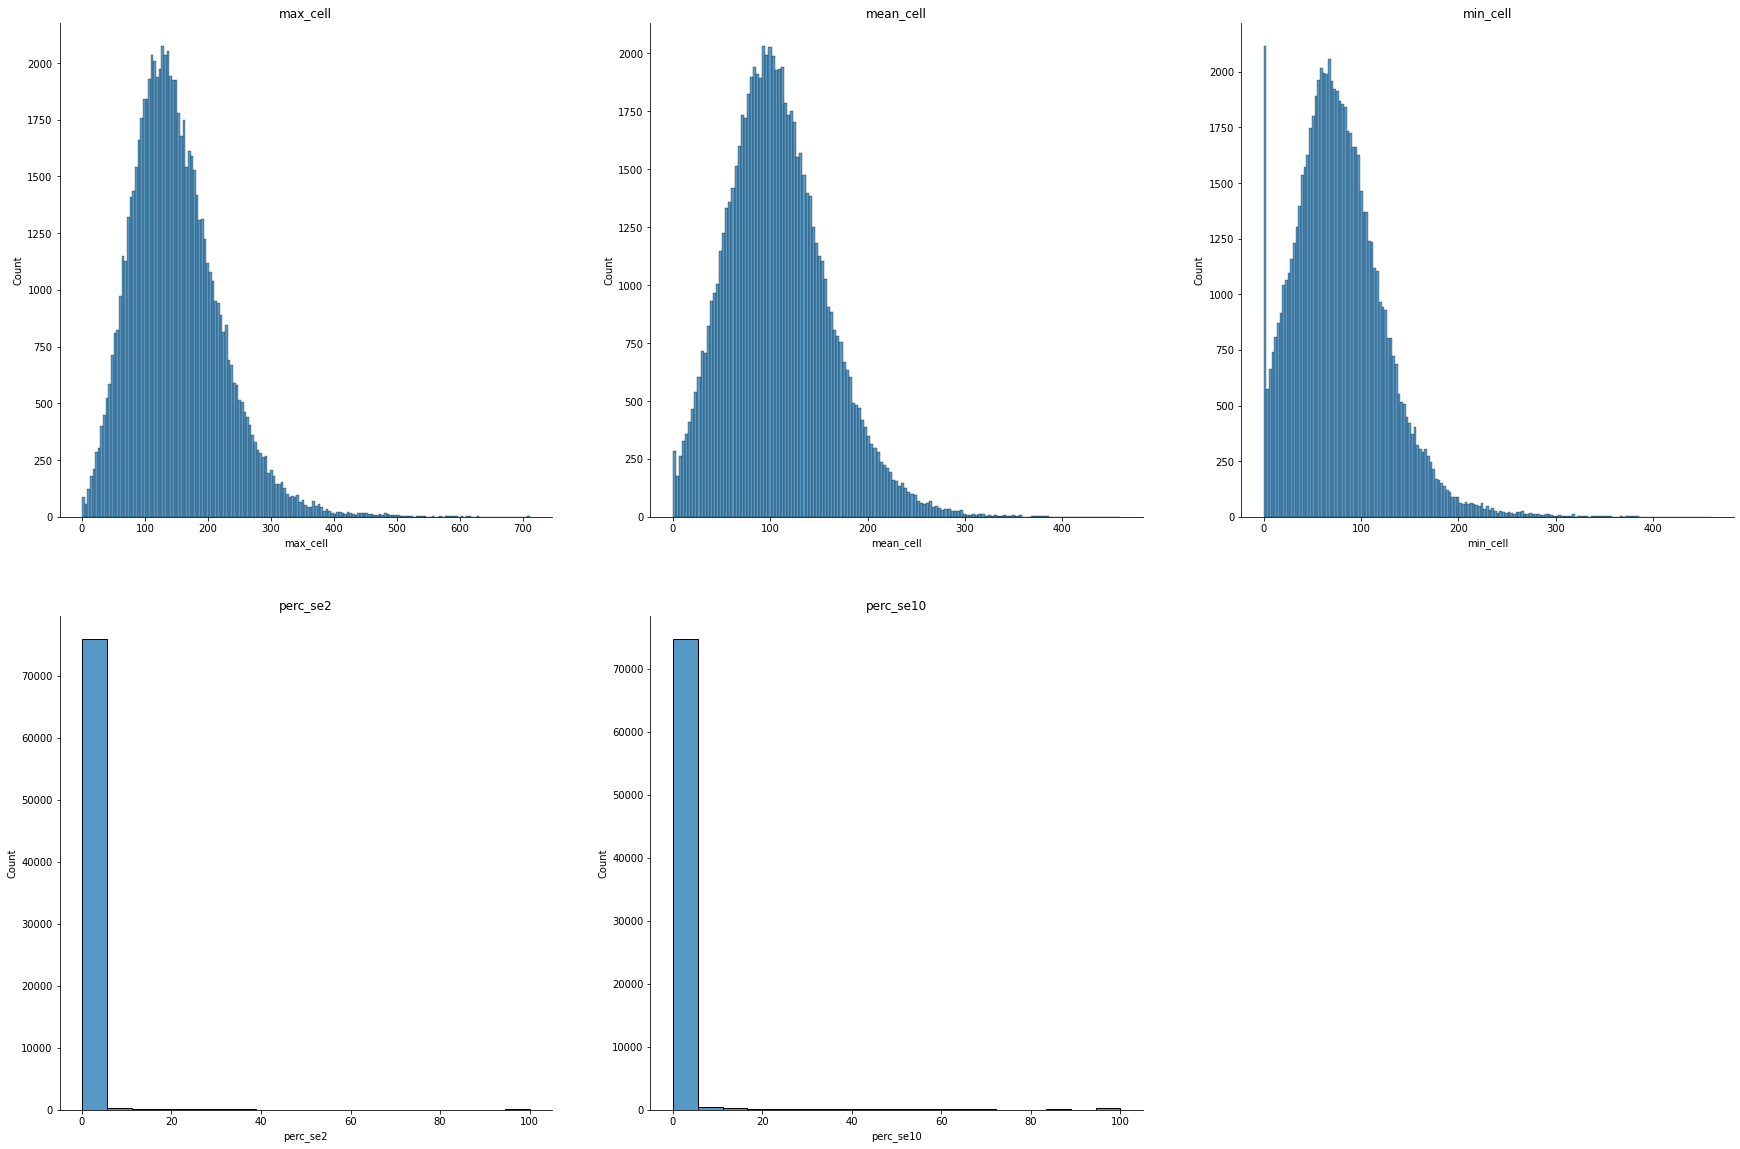

In [15]:
#plot the distributions of the different statistics
num_plots = len(cg_stats)
colp_num=3
if num_plots==1:
    colp_num=1
rows = math.ceil(num_plots / colp_num)
position = range(1, num_plots + 1)
fig=plt.figure(figsize=(30,20))
for i, s in enumerate(cg_stats):
    ax = fig.add_subplot(rows,colp_num,i+1)
    sns.histplot(df_chirpsgefs,x=s,ax=ax)
    ax.set_title(s)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

### Understand performance CHIRPS-GEFS
Question: 
- date reported of the rolling sum is the last day of the 15 days, so the start date should be -14 days, right?

In [55]:
df_bound_adm2=gpd.read_file(adm2_bound_path)

In [56]:
#read historically observed 15 day rolling sum for all dates (so not only those with dry spells), derived from CHIRPS
#this sometimes gives a not permitted error --> move the chirps_rolling_sum_path file out of the folder and back in to get it to work (dont ask me why)
df_histobs=pd.read_csv(chirps_rolling_sum_path)
df_histobs.date=pd.to_datetime(df_histobs.date)

#add start of the rolling sum 
df_histobs["date_start"]=df_histobs.date-timedelta(days=14)

#add adm2 and adm1 name
df_histobs=df_histobs.merge(df_bound_adm2[["ADM1_EN","ADM2_EN","ADM2_PCODE"]],left_on="pcode",right_on="ADM2_PCODE")

In [57]:
#merge forecast and observed
#only include dates that have a forecast, i.e. merge on right
#date in df_chirpsgefs is the first date of the forecast
df_histformerg=df_histobs.merge(df_chirpsgefs,how="right",left_on=["date_start","ADM2_EN"],right_on=["date","ADM2_EN"],suffixes=("obs","forec"))

In [58]:
df_histformerg["diff_forecobs"]=df_histformerg["mean_cell"]-df_histformerg["rollsum_15d"]

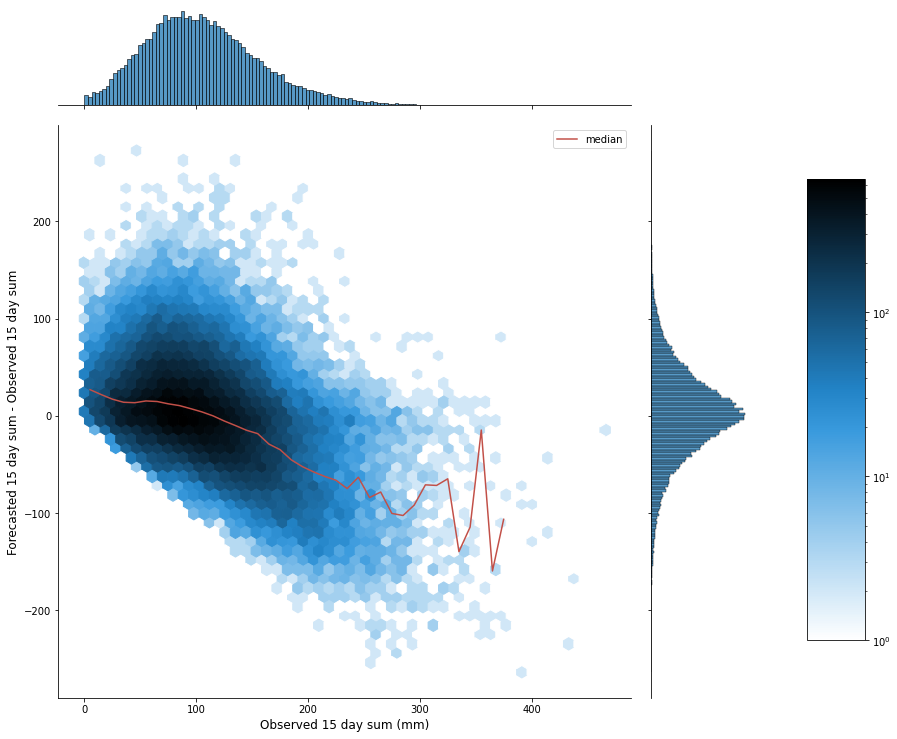

In [59]:
#plot the observed vs forecast-observed to get a feeling for the discrepancy between the two
g=sns.jointplot(data=df_histformerg,y="diff_forecobs",x="rollsum_15d", kind="hex",height=16,joint_kws={ 'bins':'log'})
#compute the average value of the difference between the forecasted and observed values
#do this in bins cause else very noisy mean
bins = np.arange(0,df_histformerg.rollsum_15d.max()+20,10)
group = df_histformerg.groupby(pd.cut(df_histformerg.rollsum_15d, bins))
plot_centers = (bins [:-1] + bins [1:])/2
plot_values = group.diff_forecobs.median()
g.ax_joint.plot(plot_centers,plot_values,color="#C25048",label="median")
g.set_axis_labels("Observed 15 day sum (mm)", "Forecasted 15 day sum - Observed 15 day sum", fontsize=12)
plt.subplots_adjust(left=0.2, right=0.8, top=0.8, bottom=0.2)  # shrink fig so cbar is visible
# make new ax object for the cbar
cbar_ax = g.fig.add_axes([.85, .25, .05, .4])  # x, y, width, height
plt.colorbar(cax=cbar_ax)
g.ax_joint.legend()
# plt.savefig(os.path.join(country_data_exploration_dir,"dryspells","plot_MWI_chirpsgefs_15days_density.png"))

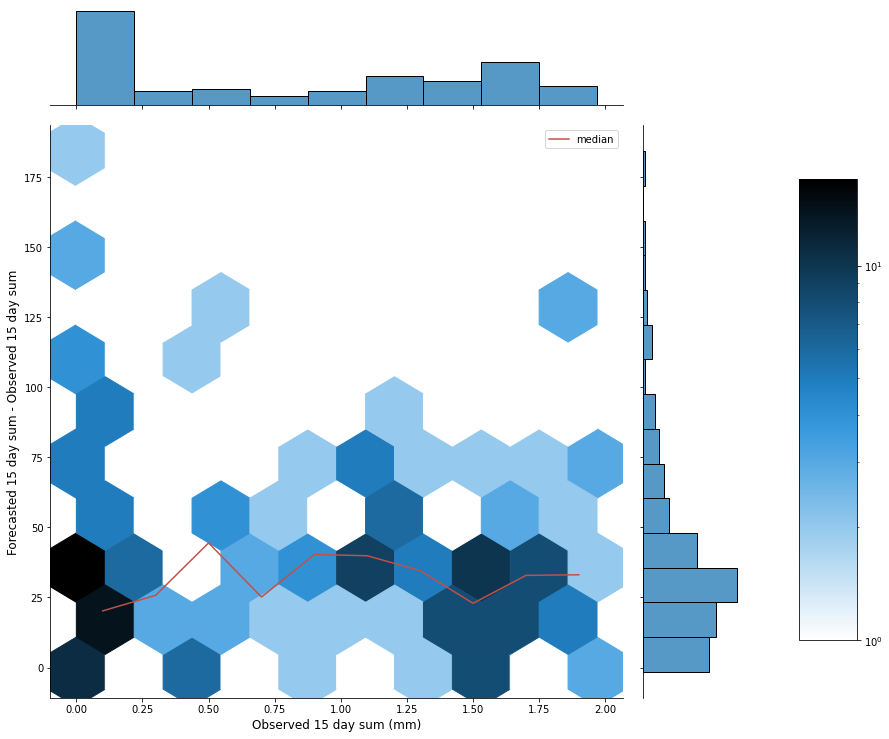

In [60]:
#plot the observed vs forecast-observed for obs<=2mm
df_sel=df_histformerg[df_histformerg.rollsum_15d<=2].sort_values("rollsum_15d")
g=sns.jointplot(data=df_sel,y="diff_forecobs",x="rollsum_15d", kind="hex",height=16,joint_kws={ 'bins':'log'})
#compute the average value of the difference between the forecasted and observed values
#do this in bins cause else very noisy mean
bins = np.arange(0,df_sel.rollsum_15d.max()+2,0.2)
group = df_sel.groupby(pd.cut(df_sel.rollsum_15d, bins))
plot_centers = (bins [:-1] + bins [1:])/2
plot_values = group.diff_forecobs.median()
g.ax_joint.plot(plot_centers,plot_values,color="#C25048",label="median")
g.set_axis_labels("Observed 15 day sum (mm)", "Forecasted 15 day sum - Observed 15 day sum", fontsize=12)
plt.subplots_adjust(left=0.2, right=0.8, top=0.8, bottom=0.2)  # shrink fig so cbar is visible
# make new ax object for the cbar
cbar_ax = g.fig.add_axes([.85, .25, .05, .4])  # x, y, width, height
plt.colorbar(cax=cbar_ax)
g.ax_joint.legend()
# plt.savefig(os.path.join(country_data_exploration_dir,"dryspells","plot_MWI_chirpsgefs_density.png"))

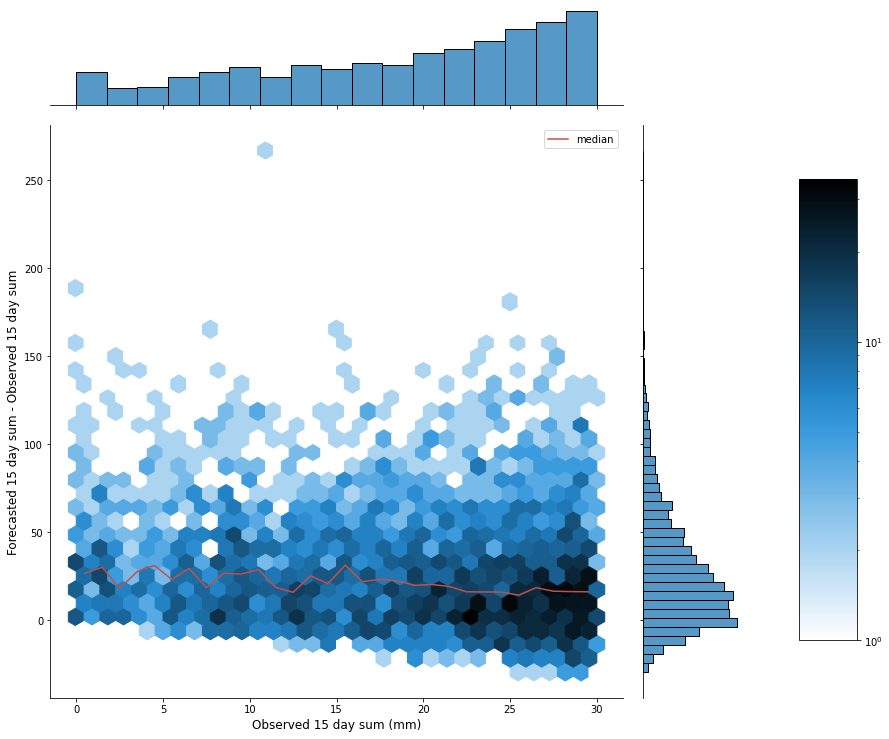

In [25]:
#plot the observed vs forecast-observed for obs<=2mm
df_sel=df_histformerg[df_histformerg.rollsum_15d<=30].sort_values("rollsum_15d")
g=sns.jointplot(data=df_sel,y="diff_forecobs",x="rollsum_15d", kind="hex",height=16,joint_kws={ 'bins':'log'})
#compute the average value of the difference between the forecasted and observed values
#do this in bins cause else very noisy mean
bins = np.arange(0,df_sel.rollsum_15d.max()+2,1)
group = df_sel.groupby(pd.cut(df_sel.rollsum_15d, bins))
plot_centers = (bins [:-1] + bins [1:])/2
plot_values = group.diff_forecobs.median()
g.ax_joint.plot(plot_centers,plot_values,color="#C25048",label="median")
g.set_axis_labels("Observed 15 day sum (mm)", "Forecasted 15 day sum - Observed 15 day sum", fontsize=12)
plt.subplots_adjust(left=0.2, right=0.8, top=0.8, bottom=0.2)  # shrink fig so cbar is visible
# make new ax object for the cbar
cbar_ax = g.fig.add_axes([.85, .25, .05, .4])  # x, y, width, height
plt.colorbar(cax=cbar_ax)
g.ax_joint.legend()
# plt.savefig(os.path.join(country_data_exploration_dir,"dryspells","plot_MWI_chirpsgefs_density.png"))

In [57]:
# # is ugly, lots of space, so comment out
# #however, couldnt find a better way cause jointplot is a facetgrid itself so becomes messy

# df_histformerg=df_histformerg.sort_values(by="month")
# g = sns.FacetGrid(df_histformerg, col="month")#, size=len(df_histformerg.month.unique()))
# g.map(sns.jointplot, "rollsum_15d","diff_forecobs",kind="hex",height=10,joint_kws={ 'bins':'log'})#, extent=[0, 50, 0, 10])

In [50]:
df_histformerg

,ID,pcode,season_approx,dateobs,total_prec,year,month,day,rollsum_10d,rollsum_14d,...,dateforec,validOn,validTo,max_cell,min_cell,mean_cell,perc_se2,perc_se10,date_forec_end,diff_forecobs
0,1.0,MW312,1999,2000-01-15,2.188816,2000.0,1.0,15.0,107.435776,122.849789,...,2000-01-01,2018-10-16,NaN,98.036362,62.076710,80.531206,0.0,0.0,2000-01-15,-42.318583
17918,8.0,MW204,2009,2010-01-20,4.865013,2010.0,1.0,20.0,64.802616,90.230600,...,2010-01-06,2018-10-16,NaN,183.314117,129.660355,153.535891,0.0,0.0,2010-01-20,51.241144
17917,8.0,MW204,2009,2010-01-19,10.476719,2010.0,1.0,19.0,59.983507,97.429733,...,2010-01-05,2018-10-16,NaN,168.909821,104.131020,136.419140,0.0,0.0,2010-01-19,38.535745
17916,8.0,MW204,2009,2010-01-18,8.370571,2010.0,1.0,18.0,58.023266,87.406676,...,2010-01-04,2018-10-16,NaN,140.491058,87.359360,109.829403,0.0,0.0,2010-01-18,19.830013
17915,8.0,MW204,2009,2010-01-17,22.346106,2010.0,1.0,17.0,56.930726,81.628819,...,2010-01-03,2018-10-16,NaN,161.009903,85.301994,124.161623,0.0,0.0,2010-01-17,36.000052
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77179,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,...,2021-03-08,2018-10-16,NaN,174.211685,174.211685,174.211685,0.0,0.0,2021-03-22,NaN
77180,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,...,2021-03-09,2018-10-16,NaN,156.969940,156.969940,156.969940,0.0,0.0,2021-03-23,NaN
77181,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,...,2021-03-10,2018-10-16,NaN,143.903870,143.903870,143.903870,0.0,0.0,2021-03-24,NaN
77182,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,...,2021-03-11,2018-10-16,NaN,175.718323,175.718323,175.718323,0.0,0.0,2021-03-25,NaN


In [64]:
# #look at values per adm1
# g = sns.FacetGrid(df_histformerg, col="ADM1_PCODE")
# g.map(sns.jointplot, "rollsum_15d","diff_forecobs",kind="hex",height=10,joint_kws={ 'bins':'log'})

In [23]:
len(df_histformerg)

77184

In [24]:
len(df_histformerg[df_histformerg.rollsum_15d<=2])

164

In [25]:
#decently close number of occurences of below 2mm of obs and forecasted, but apparently not at the same times..
len(df_histformerg[df_histformerg.mean_cell<=2])

201

In [26]:
#TODO
# #hehh would expect to not have any with during_rainy_season_bin=0?
# #using old definition of rainy season in current rolling sum file --> update and check again (cause rainy season should only become stricter so still strange). 
# #Could also be that end date is outside rainy season but start date isnt..
# df_histformerg.groupby("during_rainy_season_bin").count()
# df_histformerg[df_histformerg.during_rainy_season_bin==0]

#### Load observed dry spells

In [61]:
df_ds=pd.read_csv(dry_spells_list_path)
df_ds["dry_spell_first_date"]=pd.to_datetime(df_ds["dry_spell_first_date"])
df_ds["dry_spell_last_date"]=pd.to_datetime(df_ds["dry_spell_last_date"])
df_ds["year"]=df_ds.dry_spell_first_date.dt.year

In [62]:
df_ds.head()

,pcode,ADM2_EN,season_approx,dry_spell_first_date,dry_spell_last_date,dry_spell_duration,dry_spell_rainfall,region,year
0,MW203,Ntchisi,2004,2005-03-08,2005-03-26,19,1.2,Central,2005
1,MW205,Salima,2004,2005-03-02,2005-03-26,25,1.6,Central,2005
2,MW209,Ntcheu,2004,2005-03-02,2005-03-25,24,1.7,Central,2005
3,MW302,Machinga,2004,2005-01-31,2005-02-13,14,1.0,Southern,2005
4,MW304,Chiradzulu,2007,2008-02-10,2008-02-24,15,0.0,Southern,2008


In [63]:
#number of historically observed dry spells
len(df_ds)

45

In [64]:
len(df_ds.dry_spell_first_date.unique())

22

In [65]:
#chirpsgefs 2020 data is not complete, so these might be removed
len(df_ds[df_ds.dry_spell_first_date.dt.year==2020])

6

<AxesSubplot:xlabel='dry_spell_duration', ylabel='Count'>

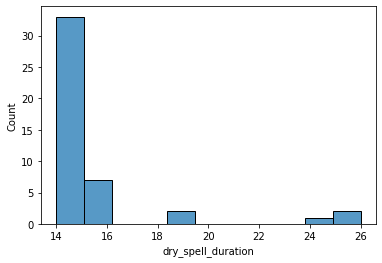

In [66]:
sns.histplot(df_ds,x="dry_spell_duration")

<Figure size 432x288 with 0 Axes>

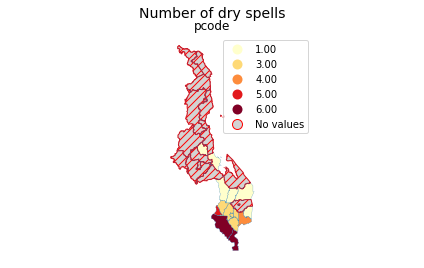

In [33]:
#get a feeling for where the dry spells occured
df_ds_adm2=df_ds.groupby(["ADM2_EN"],as_index=False).count()
df_bound_adm2=gpd.read_file(adm2_bound_path)
gdf_ds_adm2=df_bound_adm2.merge(df_ds_adm2,how="left")
fig=plot_spatial_columns(gdf_ds_adm2, ["pcode"], title="Number of dry spells", predef_bins=None,cmap='YlOrRd',colp_num=1)


Text(0, 0.5, 'Number of dry spells')

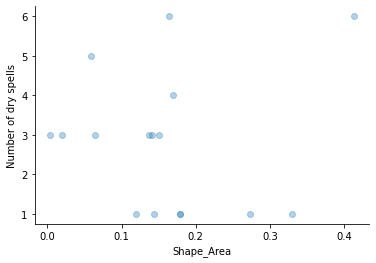

In [34]:
#check correlation with size of area and number of dry spells
g=sns.regplot(data=gdf_ds_adm2,y="pcode",x="Shape_Area",scatter_kws = {'alpha' : 1/3},fit_reg=False)
ax=g.axes
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel("Number of dry spells")

### Overlap dry spells observed and forecasted
Solely looking if any part of an observed dry spell overlaps any part of a forecasted dry spell, and the other way around. Not if their start date overlaps
i.e. this is the most loosely defined way to look at overlap

In [67]:
#create df with all dates that were part of a dry spell per adm2
#assign an ID to each dry spell, such that we can group by that later on
df_ds["ID_obs"]=range(1,len(df_ds)+1)
#important to reset the index, since that is what is being joined on
df_ds_res=df_ds.reset_index(drop=True)
#create datetimeindex per row
a = [pd.date_range(*r, freq='D') for r in df_ds_res[['dry_spell_first_date', 'dry_spell_last_date']].values]
#join the daterange with the adm2, which create a column per date, then stack to have each adm2-date combination
df_ds_daterange=df_ds_res[["ADM2_EN","ID_obs"]].join(pd.DataFrame(a)).set_index(["ADM2_EN","ID_obs"]).stack().droplevel(-1).reset_index()
df_ds_daterange.rename(columns={0:"date"},inplace=True)
#all dates in this dataframe had an observed dry spell, so add that information
df_ds_daterange["dryspell_obs"]=1

In [68]:
df_ds_daterange.head()

,ADM2_EN,ID_obs,date,dryspell_obs
0,Ntchisi,1,2005-03-08,1
1,Ntchisi,1,2005-03-09,1
2,Ntchisi,1,2005-03-10,1
3,Ntchisi,1,2005-03-11,1
4,Ntchisi,1,2005-03-12,1


In [69]:
#total number of dates that were part of a dry spell
len(df_ds_daterange)

704

In [70]:
df_ds_daterange=df_ds_daterange.drop_duplicates()

In [71]:
#there shouldn't be any duplicates so check if two lengths match
len(df_ds_daterange)

704

In [72]:
#create dataframe with all dates for which we got chirpsgefs data
df_dates=df_chirpsgefs[["date","ADM2_EN"]].sort_values(["ADM2_EN","date"])

In [73]:
#merge the observed dry spells
#merge on left, such to only include dates for which a forecast is available
df_dates=df_dates.merge(df_ds_daterange,how="left",on=["date","ADM2_EN"])
df_dates.dryspell_obs=df_dates.dryspell_obs.replace(np.nan,0)

In [74]:
#Quite some obs dry spell dates go missing
#This has two explanations: 
#1) chirps-gefs has missing data in 2020 (87 entries)
#2) a dry spell started in 2005 in Salima before 15-03 and then continued into the dry season. After 15-03 is excluded from chirps-gefs but included in obs ds (21 entries)
print(f"number of dates observed dry spells after merge: {len(df_dates[df_dates.dryspell_obs==1])}")
print(f"original number of dates with observed dry spells: {len(df_ds_daterange)}")
print(f"difference: {len(df_ds_daterange)-len(df_dates[df_dates.dryspell_obs==1])}")

number of dates observed dry spells after merge: 596
original number of dates with observed dry spells: 704
difference: 108


In [43]:
len(df_ds.dry_spell_first_date.unique())

22

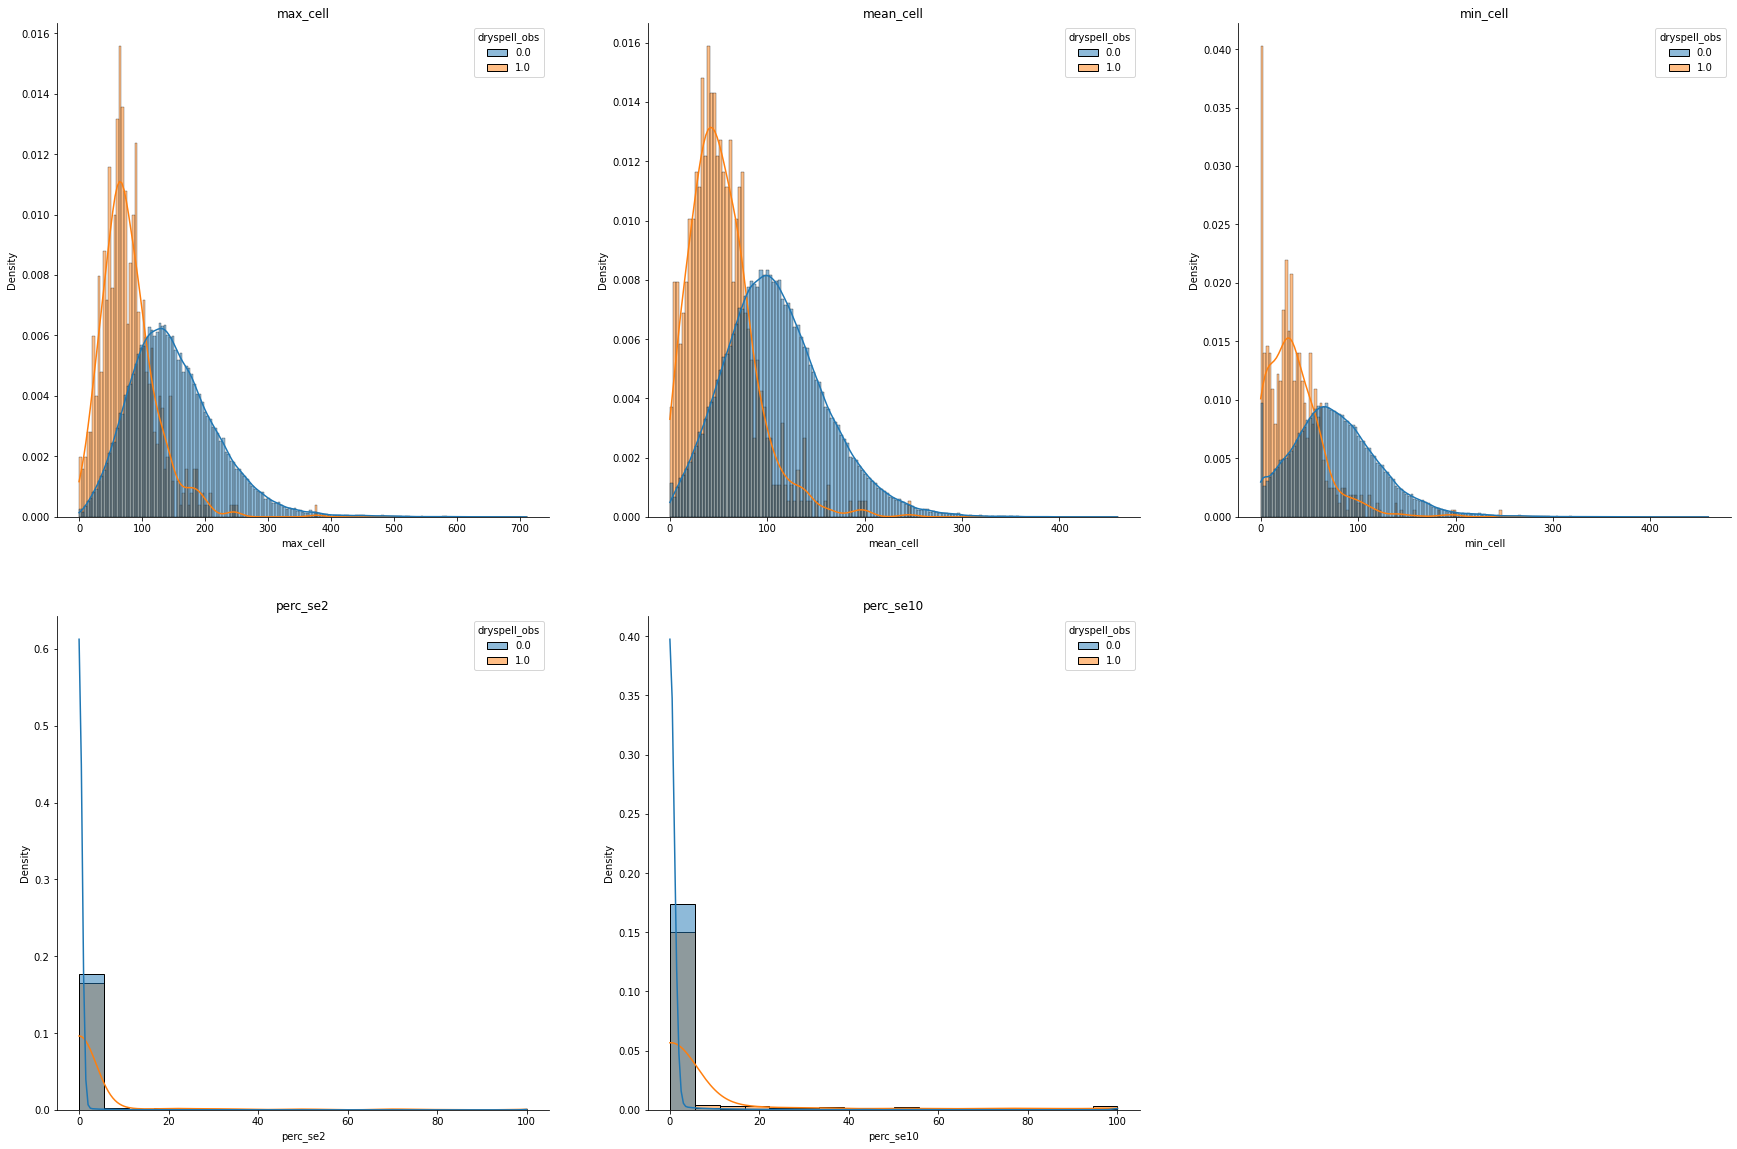

In [44]:
#this is the forecast of the next 15 days for each day that was part of a dry spell, so not perse super helpful
#e.g. last date of a dry spell is expected to not have a super low forecast
df_chirpsgefs_ds=df_chirpsgefs.merge(df_ds_daterange,how="left",on=["date","ADM2_EN"])
df_chirpsgefs_ds.dryspell_obs=df_chirpsgefs_ds.dryspell_obs.replace(np.nan,0)
num_plots = len(cg_stats)
colp_num=3
if num_plots==1:
    colp_num=1
rows = math.ceil(num_plots / colp_num)
position = range(1, num_plots + 1)
fig=plt.figure(figsize=(30,20))
for i, s in enumerate(cg_stats):
    ax = fig.add_subplot(rows,colp_num,i+1)
    sns.histplot(df_chirpsgefs_ds,x=s,ax=ax,stat="density",common_norm=False,kde=True,hue="dryspell_obs")
    ax.set_title(s)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

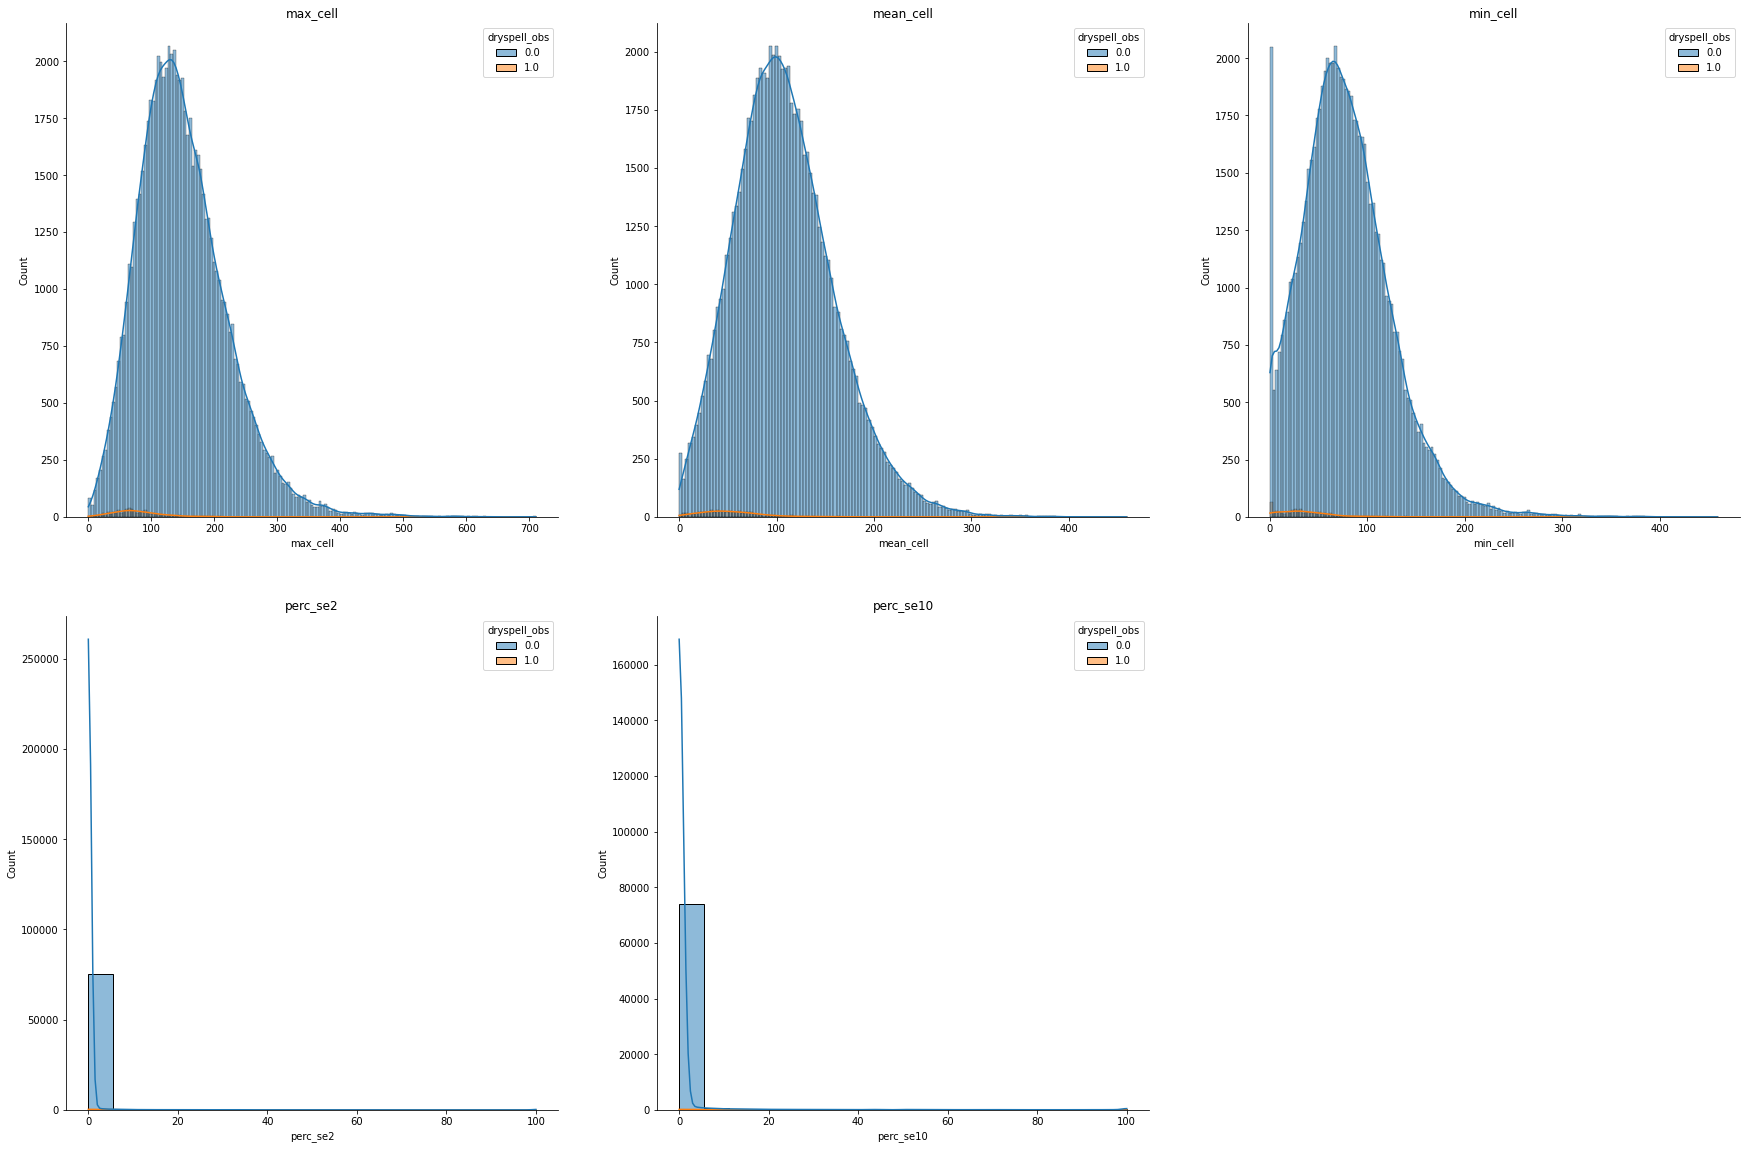

In [45]:
num_plots = len(cg_stats)
colp_num=3
if num_plots==1:
    colp_num=1
rows = math.ceil(num_plots / colp_num)
position = range(1, num_plots + 1)
fig=plt.figure(figsize=(30,20))
for i, s in enumerate(cg_stats):
    ax = fig.add_subplot(rows,colp_num,i+1)
    sns.histplot(df_chirpsgefs_ds,x=s,ax=ax,stat="count",kde=True,hue="dryspell_obs")
    ax.set_title(s)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

Compute dry spell overlap    
Step by step for 2 mm threshold, and thereafter code repeated in function to compare different thresholds

In [75]:
#select all dates where chirps-gefs forecasts dry spell
df_cg_ds=df_chirpsgefs[df_chirpsgefs.mean_cell<=2]

In [76]:
#create list of dates that were within a forecast that predicted a dry spell
df_cg_ds=df_cg_ds.sort_values(["ADM2_EN","date"]).reset_index(drop=True)
a = [pd.date_range(*r, freq='D') for r in df_cg_ds[['date', 'date_forec_end']].values]
df_cg_daterange=df_cg_ds[["ADM2_EN"]].join(pd.DataFrame(a)).set_index(["ADM2_EN"]).stack().droplevel(-1).reset_index()
df_cg_daterange.rename(columns={0:"date"},inplace=True)
df_cg_daterange["dryspell_forec"]=1

In [77]:
df_cg_daterange.head()

,ADM2_EN,date,dryspell_forec
0,Balaka,2002-03-11,1
1,Balaka,2002-03-12,1
2,Balaka,2002-03-13,1
3,Balaka,2002-03-14,1
4,Balaka,2002-03-15,1


In [78]:
len(df_cg_daterange)

3015

In [79]:
#with the forecast it is expected to be a lot of overlap
df_cg_daterange=df_cg_daterange.drop_duplicates()

In [80]:
#still many more dates forecasted to be part of a dry spell than the observed..
len(df_cg_daterange)

1772

In [81]:
len(df_ds_daterange)

704

In [82]:
#assign ID to each forecasted dry spell
#we assign one ID per any overlapping range
#e.g. if dry spell forecasted on 01-01 and 03-01 (but not 02-01), we would see this as one dry spell from 01-01 till 17-01
df_cg_daterange["ID_forec"]=df_cg_daterange.sort_values(["ADM2_EN","date"]).groupby("ADM2_EN").date.diff().dt.days.ne(1).cumsum()

In [83]:
#merge the forecasted dry spells
df_dates_comb=df_dates.merge(df_cg_daterange,how="left",on=["date","ADM2_EN"])
df_dates_comb["dryspell_forec"]=df_dates_comb["dryspell_forec"].replace(np.nan,0)

In [84]:
#Quite some forecasted dry spell dates go missing
#This is due to the start of the forecast period still being inside the rainy season, while the later dates are not
print(f"number of dates forecasted dry spells after merge: {len(df_dates_comb[df_dates_comb.dryspell_forec==1])}")
print(f"original number of dates with forecasted dry spells: {len(df_cg_daterange)}")
print(f"difference: {len(df_cg_daterange)-len(df_dates_comb[df_dates_comb.dryspell_forec==1])}")

number of dates forecasted dry spells after merge: 1114
original number of dates with forecasted dry spells: 1772
difference: 658


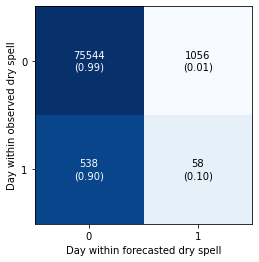

In [85]:
#number of dates with observed dry spell overlapping with forecasted
y_target =    df_dates_comb["dryspell_obs"]
y_predicted = df_dates_comb["dryspell_forec"]

cm = confusion_matrix(y_target=y_target, 
                      y_predicted=y_predicted)

fig, ax = plot_confusion_matrix(conf_mat=cm,show_absolute=True,show_normed=True) #,class_names=["No","Yes"])
ax.set_ylabel("Day within observed dry spell")
ax.set_xlabel("Day within forecasted dry spell")
plt.show()

Text(0.5, 1.0, 'Forecasted dry spells')

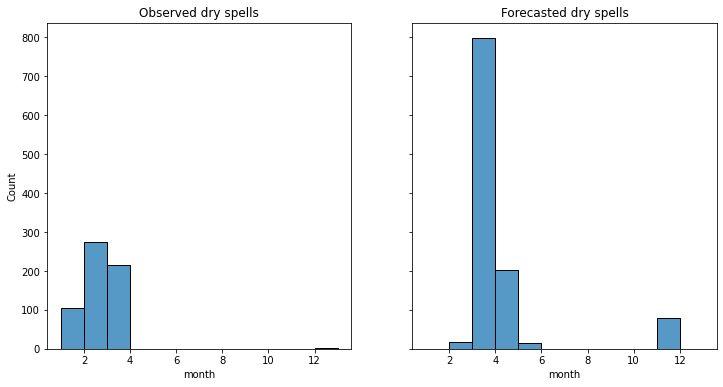

In [57]:
df_dates_comb["month"]=df_dates_comb.date.dt.month
fig, axes = plt.subplots(1, 2, sharex=True,sharey=True, figsize=(12,6))
sns.histplot(df_dates_comb[df_dates_comb.dryspell_obs==1],ax=axes[0],x="month",bins=range(df_dates_comb.month.min(),df_dates_comb.month.max()+2))
axes[0].set_title("Observed dry spells")
sns.histplot(df_dates_comb[df_dates_comb.dryspell_forec==1],ax=axes[1],x="month",bins=range(df_dates_comb.month.min(),df_dates_comb.month.max()+1))
axes[1].set_title("Forecasted dry spells")

/Users/tinkavalentijn/.virtualenvs/antact/lib/python3.8/site-packages/mlxtend/plotting/plot_confusion_matrix.py:76: RuntimeWarning: invalid value encountered in true_divide
  normed_conf_mat = conf_mat.astype('float') / total_samples
/Users/tinkavalentijn/.virtualenvs/antact/lib/python3.8/site-packages/mlxtend/plotting/plot_confusion_matrix.py:76: RuntimeWarning: invalid value encountered in true_divide
  normed_conf_mat = conf_mat.astype('float') / total_samples
/Users/tinkavalentijn/.virtualenvs/antact/lib/python3.8/site-packages/mlxtend/plotting/plot_confusion_matrix.py:76: RuntimeWarning: invalid value encountered in true_divide
  normed_conf_mat = conf_mat.astype('float') / total_samples


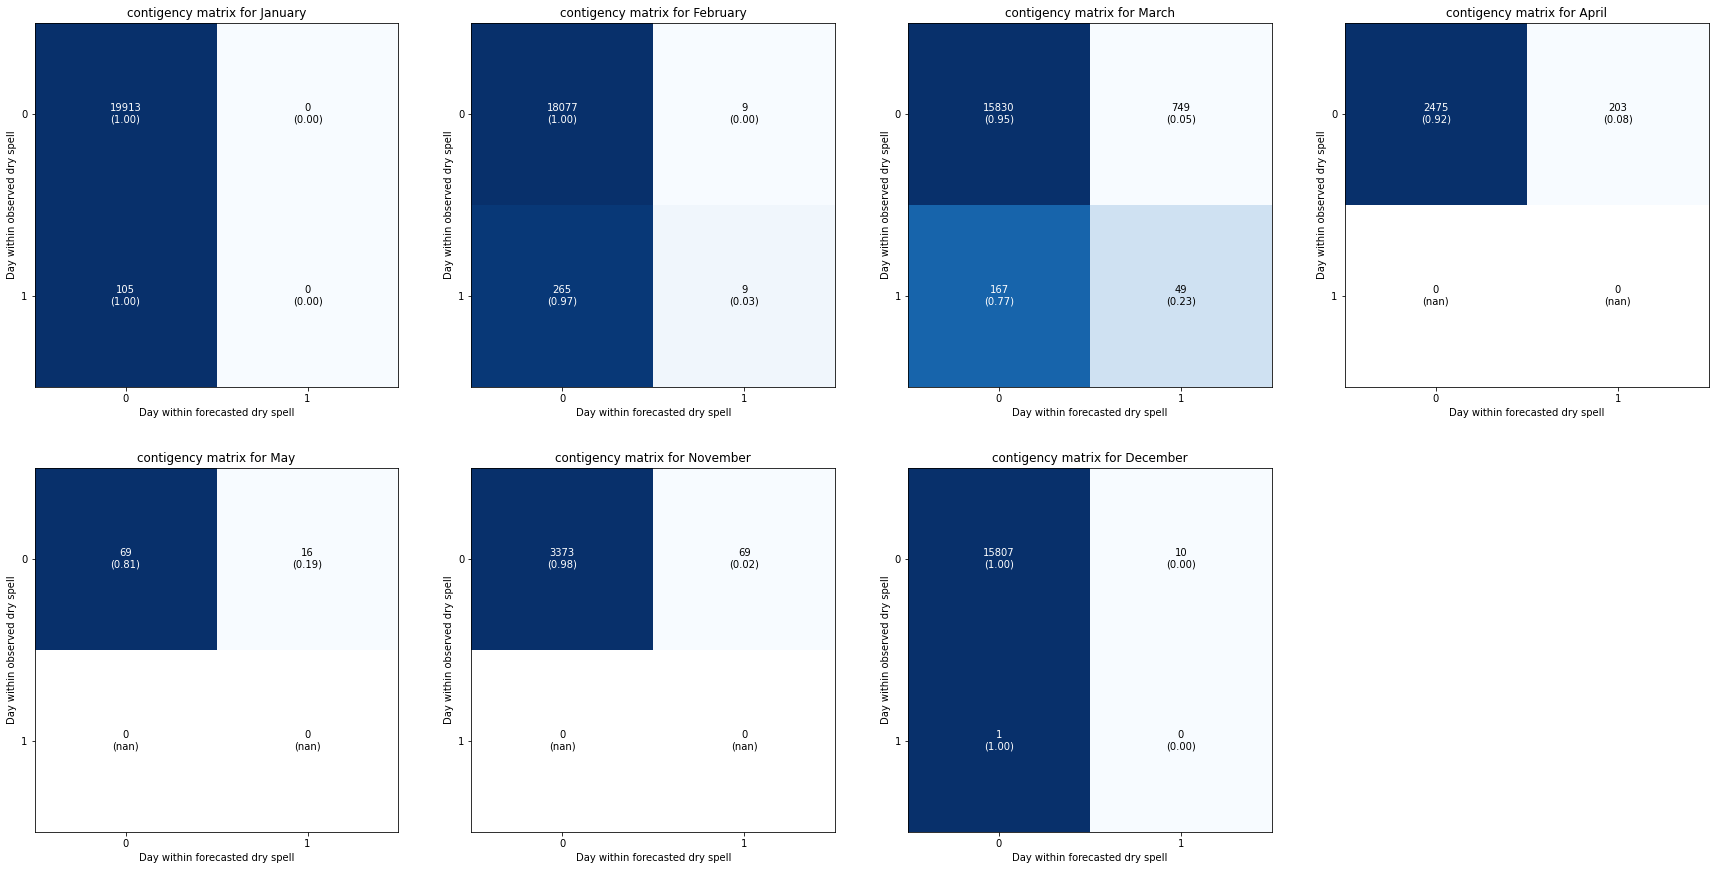

In [58]:
#number of dates with observed dry spell overlapping with forecasted per month
num_plots = len(df_dates_comb.month.unique())
colp_num=4
if num_plots==1:
    colp_num=1
rows = math.ceil(num_plots / colp_num)
position = range(1, num_plots + 1)
fig=plt.figure(figsize=(30,15))
for i, m in enumerate(df_dates_comb.sort_values(by="month").month.unique()):
    ax = fig.add_subplot(rows,colp_num,i+1)
    y_target =    df_dates_comb.loc[df_dates_comb.month==m,"dryspell_obs"]
    y_predicted = df_dates_comb.loc[df_dates_comb.month==m,"dryspell_forec"]

    cm = confusion_matrix(y_target=y_target, 
                          y_predicted=y_predicted)

    plot_confusion_matrix(conf_mat=cm,show_absolute=True,show_normed=True,axis=ax) #,class_names=["No","Yes"])
    ax.set_ylabel("Day within observed dry spell")
    ax.set_xlabel("Day within forecasted dry spell")
    ax.set_title(f"contigency matrix for {calendar.month_name[m]}")

/Users/tinkavalentijn/.virtualenvs/antact/lib/python3.8/site-packages/mlxtend/plotting/plot_confusion_matrix.py:76: RuntimeWarning: invalid value encountered in true_divide
  normed_conf_mat = conf_mat.astype('float') / total_samples


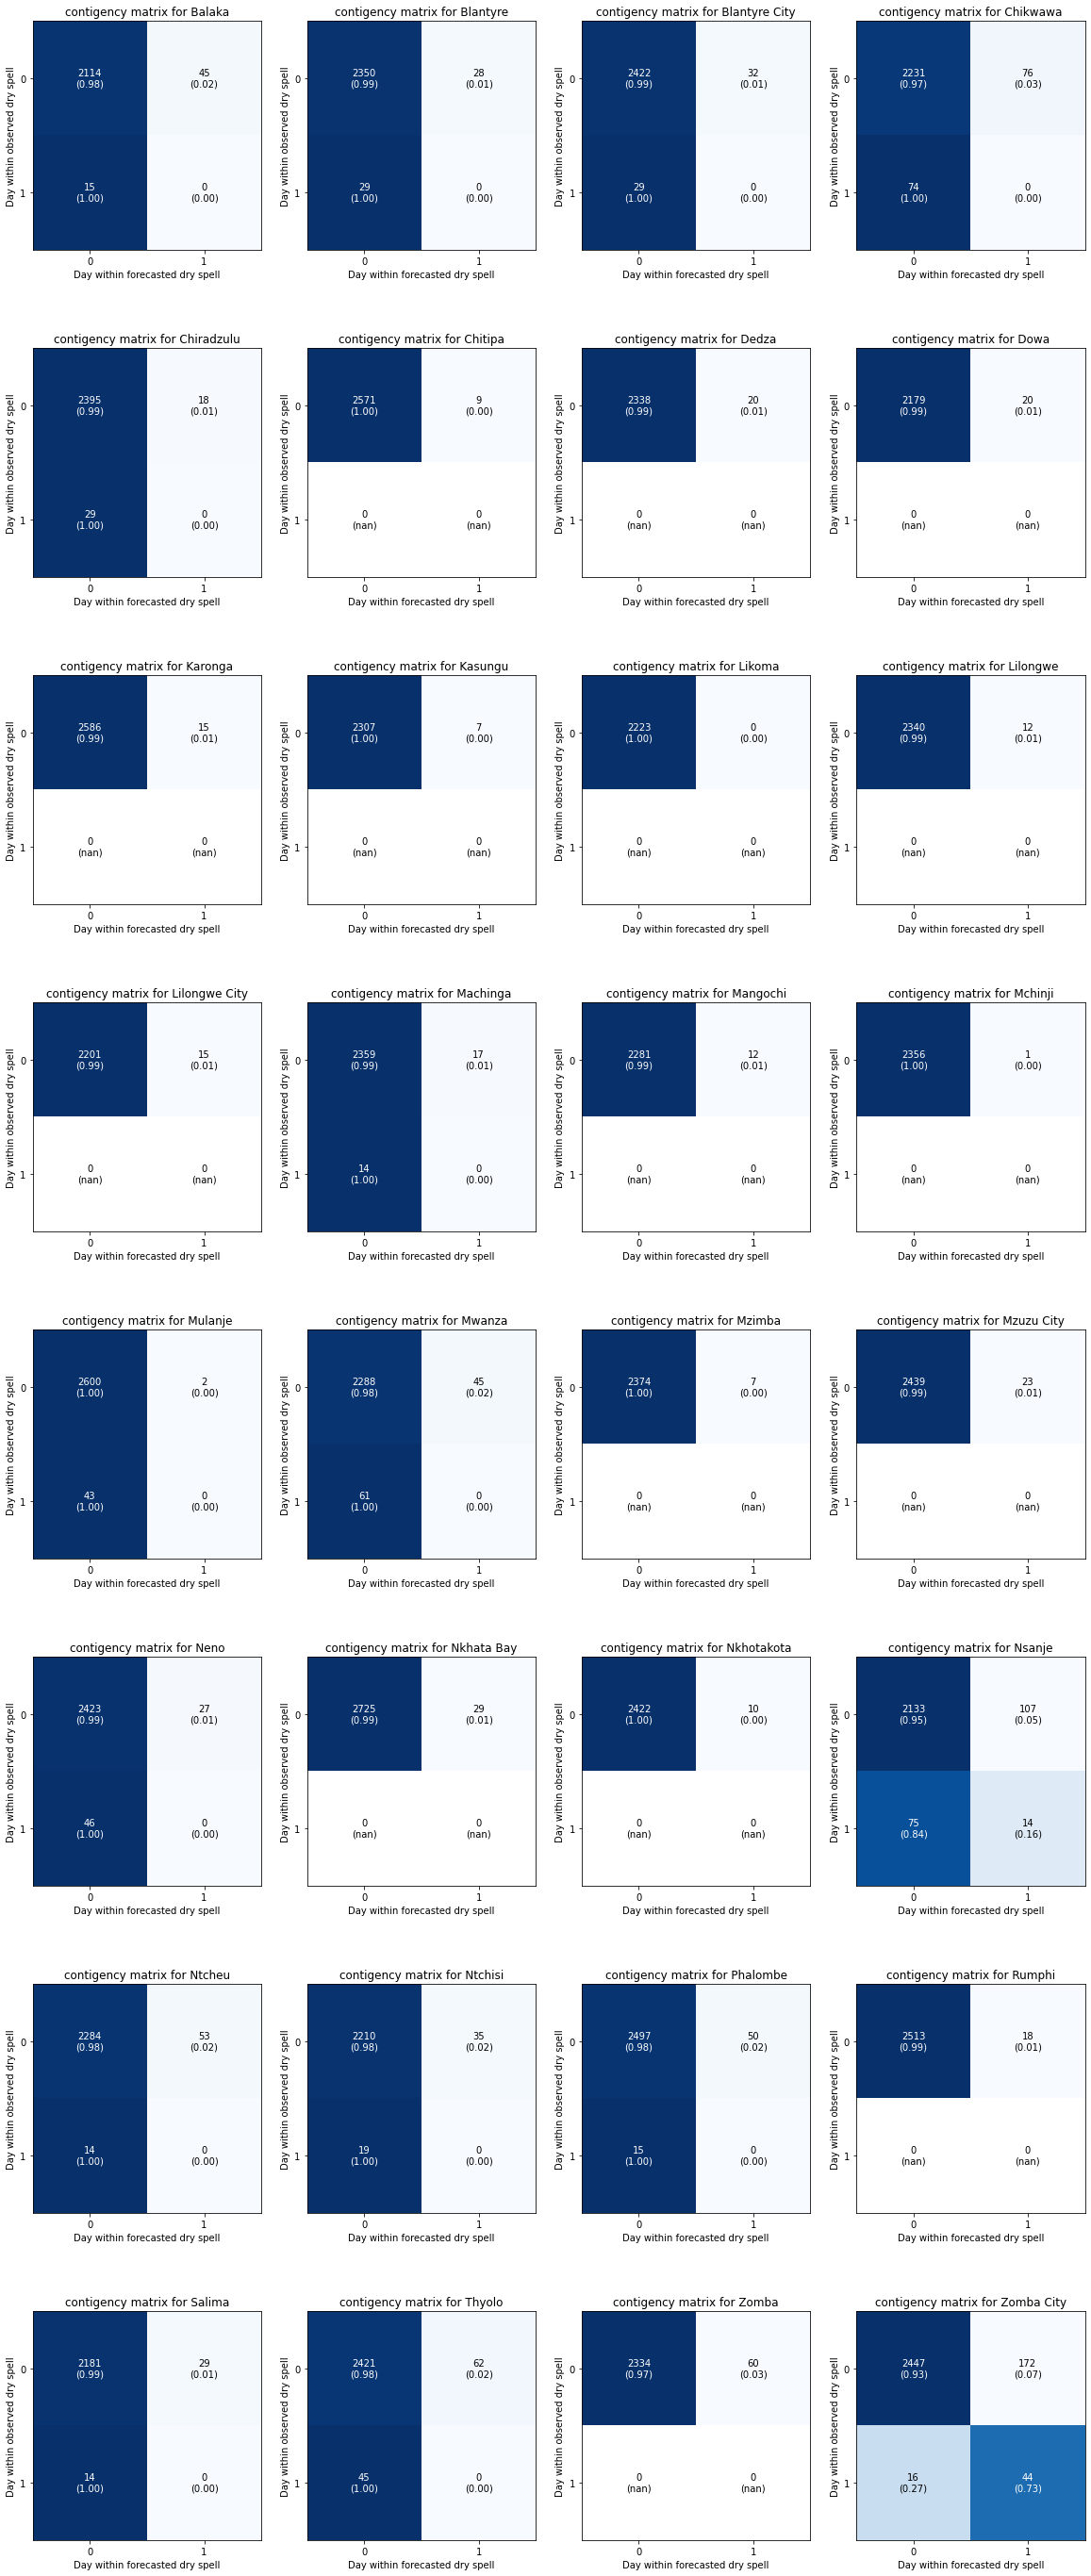

In [59]:
#number of dates with observed dry spell overlapping with forecasted per month
num_plots = len(df_dates_comb.ADM2_EN.unique())
colp_num=4
if num_plots==1:
    colp_num=1
rows = math.ceil(num_plots / colp_num)
position = range(1, num_plots + 1)
fig=plt.figure(figsize=(20,50))
for i, m in enumerate(df_dates_comb.sort_values(by="ADM2_EN").ADM2_EN.unique()):
    ax = fig.add_subplot(rows,colp_num,i+1)
    y_target =    df_dates_comb.loc[df_dates_comb.ADM2_EN==m,"dryspell_obs"]
    y_predicted = df_dates_comb.loc[df_dates_comb.ADM2_EN==m,"dryspell_forec"]

    cm = confusion_matrix(y_target=y_target, 
                          y_predicted=y_predicted)

    plot_confusion_matrix(conf_mat=cm,show_absolute=True,show_normed=True,axis=ax) #,class_names=["No","Yes"])
    ax.set_ylabel("Day within observed dry spell")
    ax.set_xlabel("Day within forecasted dry spell")
    ax.set_title(f"contigency matrix for {m}")

In [60]:
#create dataframes with start and end dates of the observed and forecasted dry spells, per ID
df_forec_dates=df_dates_comb.groupby("ID_forec",as_index=False).agg(start_date=("date","min"),end_date=("date","max"))
df_obs_dates=df_dates_comb.groupby("ID_obs",as_index=False).agg(start_date=("date","min"),end_date=("date","max"))

In [61]:
df_forec_dates.head()

,ID_forec,start_date,end_date
0,1.0,2002-03-11,2002-03-23
1,2.0,2004-03-08,2004-03-15
2,3.0,2007-03-10,2007-03-26
3,4.0,2018-03-09,2018-03-15
4,5.0,2002-03-11,2002-03-23


In [62]:
#create dataframe with all the observed dry spells and the overlapping forecasts (if any)
df_dsobsgr=df_dates_comb.groupby("ID_obs").sum()
#becomes meaningless when summing
df_dsobsgr=df_dsobsgr.drop("ID_forec",axis=1)
df_dsobsgr["ID_forec"]=df_dates_comb.groupby("ID_obs").ID_forec.apply(lambda x: x.min(skipna=True))

In [63]:
df_dsobsgr.head()

,dryspell_obs,dryspell_forec,month,ID_forec
ID_obs,,,,
1.0,19.0,0.0,57,NaN
2.0,14.0,0.0,42,NaN
3.0,14.0,0.0,42,NaN
4.0,14.0,0.0,27,NaN
5.0,15.0,0.0,30,NaN


In [64]:
df_obsid=df_dsobsgr.reset_index().merge(df_forec_dates[["ID_forec","start_date"]],how="left",on="ID_forec").rename(columns={"start_date":"start_date_forec"})
df_obsid=df_obsid.merge(df_obs_dates[["ID_obs","start_date"]],how="left",on="ID_obs").rename(columns={"start_date":"start_date_obs"})
#how many days late the forecast started forecasting the dry spell (negative if it anticipated)
df_obsid["days_late"]=(df_obsid.start_date_forec-df_obsid.start_date_obs).dt.days

In [65]:
df_obsid.sort_values("start_date_obs")

,ID_obs,dryspell_obs,dryspell_forec,month,ID_forec,start_date_forec,start_date_obs,days_late
24,30.0,14.0,14.0,33,55.0,2002-02-19,2002-02-20,-1.0
25,31.0,16.0,0.0,48,NaN,NaT,2004-03-10,NaN
31,37.0,16.0,0.0,30,NaN,NaT,2005-01-30,NaN
8,11.0,16.0,0.0,30,NaN,NaT,2005-01-30,NaN
19,24.0,14.0,0.0,27,NaN,NaT,2005-01-31,NaN
3,4.0,14.0,0.0,27,NaN,NaT,2005-01-31,NaN
26,32.0,14.0,0.0,27,NaN,NaT,2005-01-31,NaN
34,40.0,26.0,16.0,78,94.0,2005-03-02,2005-03-01,1.0
1,2.0,14.0,0.0,42,NaN,NaT,2005-03-02,NaN
2,3.0,14.0,0.0,42,NaN,NaT,2005-03-02,NaN


In [66]:
print(f"The recall (TP/(TP+FN)) is: {round(len(df_obsid[df_obsid.dryspell_forec>0])/len(df_obsid),4)}")
print(f"{len(df_obsid)} dry spells were observed of which {len(df_obsid[~df_obsid.ID_forec.isnull()])} overlapped with forecasted dry spells")

The recall (TP/(TP+FN)) is: 0.1026
39 dry spells were observed of which 4 overlapped with forecasted dry spells


In [67]:
#repeat the same excercise, but now to see how many forecasted dryspells overlap observed dry spells
#--> can compute precision from that
df_dsforgr=df_dates_comb.groupby("ID_forec").sum()
df_dsforgr=df_dsforgr.drop("ID_obs",axis=1)
df_dsforgr["ID_obs"]=df_dates_comb.groupby("ID_forec").ID_obs.apply(lambda x: x.min(skipna=True))
df_forid=df_dsforgr.reset_index().merge(df_obs_dates[["ID_obs","start_date"]],how="left",on="ID_obs").rename(columns={"start_date":"start_date_obs"})
df_forid=df_forid.merge(df_forec_dates[["ID_forec","start_date"]],how="left",on="ID_forec").rename(columns={"start_date":"start_date_forec"})
df_forid["days_late"]=(df_forid.start_date_obs-df_forid.start_date_forec).dt.days

In [68]:
#the overlap of observed dry spells for precision might not be the same as recall
#this can be caused if several forecasted dry spells fall within one observed dry spell
#however the difference shouldn't be large
print(f"The precision (TP/(TP+FP)) is: {round(len(df_forid[df_forid.dryspell_obs>0])/len(df_forid),4)}")
print(f"{len(df_forid)} dry spells were forecasted of which {len(df_forid[~df_forid.ID_obs.isnull()])} overlapped with observed dry spells")

The precision (TP/(TP+FP)) is: 0.0388
103 dry spells were forecasted of which 4 overlapped with observed dry spells


In [69]:
#ID_obs indicates the number of forecasted dry spells that matched observations per month
df_forid["start_month_forec"]=df_forid.start_date_forec.dt.month
df_forid.groupby("start_month_forec").count()

,ID_forec,dryspell_obs,dryspell_forec,month,ID_obs,start_date_obs,start_date_forec,days_late
start_month_forec,,,,,,,,
2,2,2,2,2,1,1,2,1
3,67,67,67,67,3,3,67,3
4,29,29,29,29,0,0,29,0
11,5,5,5,5,0,0,5,0


In [70]:
#compile all above code into function such that can test different thresholds
def stats_threshold(df_dates,df_chirpsgefs,threshold):
    df_cg_ds=df_chirpsgefs[df_chirpsgefs.mean_cell<=threshold]
    df_cg_ds=df_cg_ds.sort_values(["ADM2_EN","date"]).reset_index(drop=True)
    a = [pd.date_range(*r, freq='D') for r in df_cg_ds[['date', 'date_forec_end']].values]
    df_cg_daterange=df_cg_ds[["ADM2_EN"]].join(pd.DataFrame(a)).set_index(["ADM2_EN"]).stack().droplevel(-1).reset_index()
    df_cg_daterange.rename(columns={0:"date"},inplace=True)
    df_cg_daterange["dryspell_forec"]=1
    df_cg_daterange=df_cg_daterange.drop_duplicates()
    df_cg_daterange["ID_forec"]=df_cg_daterange.sort_values(["ADM2_EN","date"]).groupby("ADM2_EN").date.diff().dt.days.ne(1).cumsum()
    df_dates_comb=df_dates.merge(df_cg_daterange,how="left",on=["date","ADM2_EN"])
    df_dates_comb["dryspell_forec"]=df_dates_comb["dryspell_forec"].replace(np.nan,0)
    df_forec_dates=df_dates_comb.groupby("ID_forec",as_index=False).agg(start_date=("date","min"),end_date=("date","max"))
    df_obs_dates=df_dates_comb.groupby("ID_obs",as_index=False).agg(start_date=("date","min"),end_date=("date","max"))
    df_dsobsgr=df_dates_comb.groupby("ID_obs").sum()
    df_dsobsgr=df_dsobsgr.drop("ID_forec",axis=1)
    df_dsobsgr["ID_forec"]=df_dates_comb.groupby("ID_obs").ID_forec.apply(lambda x: x.min(skipna=True))
    df_obsid=df_dsobsgr.reset_index().merge(df_forec_dates[["ID_forec","start_date"]],how="left",on="ID_forec").rename(columns={"start_date":"start_date_forec"})
    df_obsid=df_obsid.merge(df_obs_dates[["ID_obs","start_date"]],how="left",on="ID_obs").rename(columns={"start_date":"start_date_obs"})
    df_obsid["days_late"]=(df_obsid.start_date_forec-df_obsid.start_date_obs).dt.days
    df_dsforgr=df_dates_comb.groupby("ID_forec").sum()
    df_dsforgr=df_dsforgr.drop("ID_obs",axis=1)
    df_dsforgr["ID_obs"]=df_dates_comb.groupby("ID_forec").ID_obs.apply(lambda x: x.min(skipna=True))
    df_forid=df_dsforgr.reset_index().merge(df_obs_dates[["ID_obs","start_date"]],how="left",on="ID_obs").rename(columns={"start_date":"start_date_obs"})
    df_forid=df_forid.merge(df_forec_dates[["ID_forec","start_date"]],how="left",on="ID_forec").rename(columns={"start_date":"start_date_forec"})
    df_dates_tn=df_dates_comb[(df_dates_comb.dryspell_obs==0)&(df_dates_comb.dryspell_forec==0)]
    pd.options.mode.chained_assignment = None  # default='warn'
    df_dates_tn.loc[:,"ID_tn"]=df_dates_tn.sort_values(["ADM2_EN","date"]).groupby("ADM2_EN").date.diff().dt.days.ne(1).cumsum()
    tn=len(df_dates_tn.ID_tn.unique())

    recall=len(df_obsid[df_obsid.dryspell_forec>0])/len(df_obsid)
    num_obs=len(df_obsid)
    num_obsfor=len(df_obsid[~df_obsid.ID_forec.isnull()])
    precision=len(df_forid[df_forid.dryspell_obs>0])/len(df_forid)
    num_for=len(df_forid)
    num_forobs=len(df_forid[~df_forid.ID_obs.isnull()])
    return recall,precision,num_obs,num_obsfor,num_for,num_forobs,tn

The recall (TP/(TP+FN)) with 2mm threshold is: 0.1026 (4/39)
The precision (TP/(TP+FP))  with 2mm threshold is: 0.0388 (4/103)
The miss rate (FP/(TP+FP))  with 2mm threshold is: 0.9612 (99/103)



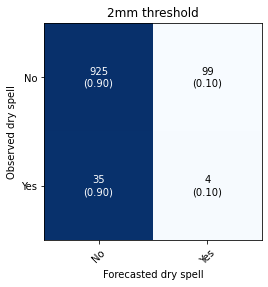

The recall (TP/(TP+FN)) with 5mm threshold is: 0.2564 (10/39)
The precision (TP/(TP+FP))  with 5mm threshold is: 0.0579 (11/190)
The miss rate (FP/(TP+FP))  with 5mm threshold is: 0.9421 (179/190)



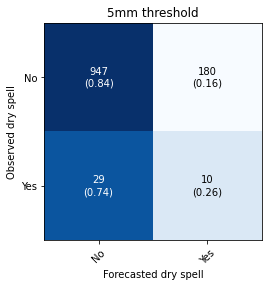

The recall (TP/(TP+FN)) with 10mm threshold is: 0.4615 (18/39)
The precision (TP/(TP+FP))  with 10mm threshold is: 0.0534 (18/337)
The miss rate (FP/(TP+FP))  with 10mm threshold is: 0.9466 (319/337)



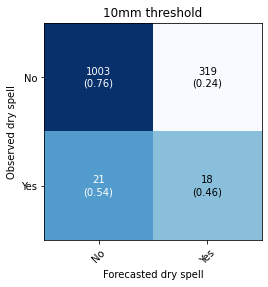

The recall (TP/(TP+FN)) with 15mm threshold is: 0.6667 (26/39)
The precision (TP/(TP+FP))  with 15mm threshold is: 0.0525 (26/495)
The miss rate (FP/(TP+FP))  with 15mm threshold is: 0.9475 (469/495)



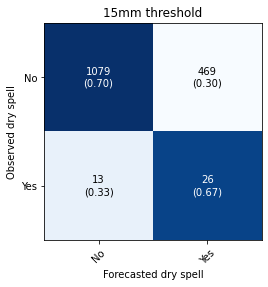

The recall (TP/(TP+FN)) with 20mm threshold is: 0.7692 (30/39)
The precision (TP/(TP+FP))  with 20mm threshold is: 0.049 (31/633)
The miss rate (FP/(TP+FP))  with 20mm threshold is: 0.951 (602/633)



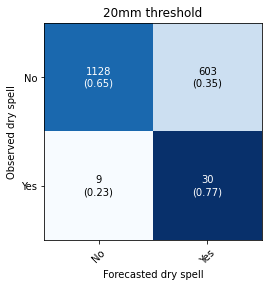

The recall (TP/(TP+FN)) with 25mm threshold is: 0.9487 (37/39)
The precision (TP/(TP+FP))  with 25mm threshold is: 0.0467 (36/771)
The miss rate (FP/(TP+FP))  with 25mm threshold is: 0.9533 (735/771)



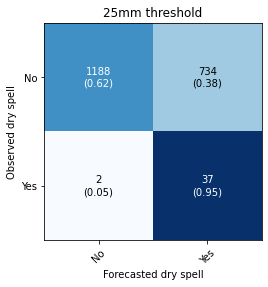

In [71]:
threshold_list=[2,5,10,15,20,25]
df_pr=pd.DataFrame(threshold_list,columns=["threshold"]).set_index('threshold')
for threshold in threshold_list:
    recall,precision,num_obs,num_obsfor,num_for,num_forobs,tn=stats_threshold(df_dates,df_chirpsgefs,threshold)
#     df_pr.loc[threshold,["recall","precision","num_obs","num_obsfor","num_for","num_forobs","tn"]]=recall,precision,num_obs,num_obsfor,num_for,num_forobs,tn
    print(f"The recall (TP/(TP+FN)) with {threshold}mm threshold is: {round(recall,4)} ({num_obsfor}/{num_obs})")
    print(f"The precision (TP/(TP+FP))  with {threshold}mm threshold is: {round(precision,4)} ({num_forobs}/{num_for})")
    print(f"The miss rate (FP/(TP+FP))  with {threshold}mm threshold is: {round((num_for-num_forobs)/(num_for),4)} ({num_for-num_forobs}/{num_for})\n")
    cm=np.array([[tn, num_for-num_obsfor],[num_obs-num_obsfor, num_obsfor]])
    plot_confusion_matrix(conf_mat=cm,show_absolute=True,show_normed=True,class_names=["No","Yes"])#,axis=ax)
    plt.xlabel("Forecasted dry spell")
    plt.ylabel("Observed dry spell")
    plt.title(f"{threshold}mm threshold")
    plt.show()
    # df_pr.to_csv(os.path.join(country_data_processed_dir,"dry_spells","chirpsgefs",f"chirpsgefs_{ds_meth}_precision_recall_thresholds.csv"))

### Experiment extent

In [72]:
def stats_threshold_extent(df_dates,df_chirpsgefs,threshold):
    df_cg_ds=df_chirpsgefs[df_chirpsgefs.mean_cell<=threshold]
    df_cg_ds=df_cg_ds.sort_values(["ADM2_EN","date"]).reset_index(drop=True)
    a = [pd.date_range(*r, freq='D') for r in df_cg_ds[['date', 'date_forec_end']].values]
    df_cg_daterange=df_cg_ds[["ADM2_EN"]].join(pd.DataFrame(a)).set_index(["ADM2_EN"]).stack().droplevel(-1).reset_index()
    df_cg_daterange.rename(columns={0:"date"},inplace=True)
    df_cg_daterange["dryspell_forec"]=1
    df_cg_daterange=df_cg_daterange.drop_duplicates()
    df_cg_daterange["ID_forec"]=df_cg_daterange.sort_values(["ADM2_EN","date"]).groupby("ADM2_EN").date.diff().dt.days.ne(1).cumsum()
    df_dates_comb=df_dates.merge(df_cg_daterange,how="left",on=["date","ADM2_EN"])
    df_dates_comb["dryspell_forec"]=df_dates_comb["dryspell_forec"].replace(np.nan,0)
    df_forec_dates=df_dates_comb.groupby("ID_forec",as_index=False).agg(start_date=("date","min"),end_date=("date","max"))
    df_obs_dates=df_dates_comb.groupby("ID_obs",as_index=False).agg(start_date=("date","min"),end_date=("date","max"))
    df_dsobsgr=df_dates_comb.groupby("ID_obs").sum()
    df_dsobsgr=df_dsobsgr.drop("ID_forec",axis=1)
    df_dsobsgr["ID_forec"]=df_dates_comb.groupby("ID_obs").ID_forec.apply(lambda x: x.min(skipna=True))
    df_obsid=df_dsobsgr.reset_index().merge(df_forec_dates[["ID_forec","start_date"]],how="left",on="ID_forec").rename(columns={"start_date":"start_date_forec"})
    df_obsid=df_obsid.merge(df_obs_dates[["ID_obs","start_date"]],how="left",on="ID_obs").rename(columns={"start_date":"start_date_obs"})
    df_obsid["days_late"]=(df_obsid.start_date_forec-df_obsid.start_date_obs).dt.days
    df_dsforgr=df_dates_comb.groupby("ID_forec").sum()
    df_dsforgr=df_dsforgr.drop("ID_obs",axis=1)
    df_dsforgr["ID_obs"]=df_dates_comb.groupby("ID_forec").ID_obs.apply(lambda x: x.min(skipna=True))
    df_forid=df_dsforgr.reset_index().merge(df_obs_dates[["ID_obs","start_date"]],how="left",on="ID_obs").rename(columns={"start_date":"start_date_obs"})
    df_forid=df_forid.merge(df_forec_dates[["ID_forec","start_date"]],how="left",on="ID_forec").rename(columns={"start_date":"start_date_forec"})
    df_dates_tn=df_dates_comb[(df_dates_comb.dryspell_obs==0)&(df_dates_comb.dryspell_forec==0)]
    return df_dates_comb,df_obsid,df_forid

In [73]:
df_dates_comb,df_obsid,df_forid=stats_threshold_extent(df_dates,df_chirpsgefs,25)

In [74]:
df_obsid["date_month"]=df_obsid.start_date_obs.dt.to_period("M")

In [75]:
df_obsid["forecasted"]=np.where(df_obsid.ID_forec.isnull(),0,1)

In [76]:
df_obsid.groupby("date_month").agg({"forecasted":["sum","count"]})#,"forecasted":"count"})

forecasted      
                  sum count
date_month                 
2002-02             1     1
2004-03             1     1
2005-01             5     5
2005-03             4     4
2008-02            10    10
2009-12             1     1
2010-01             4     5
2011-02             5     6
2017-03             3     3
2018-01             1     1
2018-03             2     2

In [77]:
df_forid["observed"]=np.where(df_forid.ID_obs.isnull(),0,1)

In [78]:
df_forid["date_month"]=df_forid.start_date_forec.dt.to_period("M")

In [79]:
df_forid

,ID_forec,dryspell_obs,dryspell_forec,ID_obs,start_date_obs,start_date_forec,observed,date_month
0,1.0,0.0,28.0,NaN,NaT,2000-12-16,0,2000-12
1,2.0,0.0,30.0,NaN,NaT,2001-11-26,0,2001-11
2,3.0,0.0,26.0,NaN,NaT,2002-02-26,0,2002-02
3,4.0,0.0,16.0,NaN,NaT,2002-12-26,0,2002-12
4,5.0,0.0,18.0,NaN,NaT,2003-03-07,0,2003-03
...,...,...,...,...,...,...,...,...
766,767.0,0.0,15.0,NaN,NaT,2015-12-28,0,2015-12
767,768.0,15.0,24.0,41.0,2017-03-07,2017-03-03,1,2017-03
768,769.0,16.0,18.0,42.0,2018-03-03,2018-03-06,1,2018-03
769,770.0,0.0,1.0,NaN,NaT,2018-04-12,0,2018-04


In [80]:
df_fordm=df_forid.groupby("date_month").agg(count=('ID_forec', 'count'),obs_ds=("observed","sum"))

### Transform data for heatmap
We got a R script that creates a real nice heatmap showing the dry spells per adm2 for each year. Since we also use this code to analyze observed dry spells, it is nice to keep the layout the same for comparing observed and forecasted.    
Thus, transform the data such that it can be given as input to the R script
On the GDrive you can find the outputted heatmap from the R script that shows the observed and forecasted dry spells clearly over time

In [81]:
#create dataframe with all dates for which we got chirpsgefs data
df_dates_viz=df_chirpsgefs[["date","ADM2_EN","ADM2_PCODE"]].sort_values(["ADM2_EN","date"])
df_dates_viz.rename(columns={"ADM2_PCODE":"pcode"},inplace=True)
#merge the observed dry spells
#merge on outer instead of left for visualization
df_dates_viz=df_dates_viz.merge(df_ds_daterange,how="outer",on=["date","ADM2_EN"]) #left
df_dates_viz.dryspell_obs=df_dates_viz.dryspell_obs.replace(np.nan,0)

In [82]:
#select all dates where chirps-gefs forecasts dry spell
df_cg_ds=df_chirpsgefs[df_chirpsgefs.mean_cell<=threshold]
#create list of dates that were within a forecast that predicted a dry spell
df_cg_ds=df_cg_ds.sort_values(["ADM2_EN","date"]).reset_index(drop=True)
a = [pd.date_range(*r, freq='D') for r in df_cg_ds[['date', 'date_forec_end']].values]
df_cg_daterange=df_cg_ds[["ADM2_EN"]].join(pd.DataFrame(a)).set_index(["ADM2_EN"]).stack().droplevel(-1).reset_index()
df_cg_daterange.rename(columns={0:"date"},inplace=True)
df_cg_daterange["dryspell_forec"]=1
#with the forecast it is expected to be a lot of overlap
df_cg_daterange=df_cg_daterange.drop_duplicates()

In [83]:
#merge the forecasted dry spells
df_dates_viz_comb=df_dates_viz.merge(df_cg_daterange,how="outer",on=["date","ADM2_EN"]) #left
df_dates_viz_comb["dryspell_forec"]=df_dates_viz_comb["dryspell_forec"].replace(np.nan,0)

In [84]:
def label_ds(row):
    if row["dryspell_obs"]==1 and row["dryspell_forec"]==1:
        return 3
    elif row["dryspell_obs"]==1:
        return 2
    elif row["dryspell_forec"]==1:
        return 1
    else:
        return 0

In [85]:
#encode dry spells and whether it was none, only observed, only forecasted, or both
df_dates_viz_comb["dryspell_match"]=df_dates_viz_comb.apply(lambda row:label_ds(row),axis=1)

In [86]:
#add dates that are not present in df, i.e. outside rainy season
df_dates_viz_filled=df_dates_viz_comb.sort_values('date').set_index(['date']).groupby('pcode').apply(lambda x: x.reindex(pd.date_range(pd.to_datetime('01-01-2000'), pd.to_datetime('31-12-2020'), name='date'),fill_value=0).drop('pcode',axis=1).reset_index()).reset_index().drop("level_1",axis=1)

In [87]:
#cause for now we only wanna show till end of 2020 cause no obs dry spells data after that
#could also choose to only do till 2019 cause no chirps-gefs for 2020, but wanted to keep data the same as obs dry spells
df_dates_viz_filled=df_dates_viz_filled[df_dates_viz_filled.date.dt.year<=2020]

In [88]:
# df_dates_viz_filled.drop(["ID_obs"],axis=1).to_csv(os.path.join(country_data_processed_dir,"dry_spells","chirpsgefs",f"dryspells_chirpsgefs_dates_viz_{ds_meth}_th{threshold}.csv"))

#### Plot raw raster values
Of CHIRPS-GEFS for dates where an observed dry spell started --> goal to better understand the patterns at those dates and if there would be a better way of aggregation. Conclusion that there doesnt seem to be a consistent pattern :( 

In [89]:
chirpsgefs_dir = os.path.join(config.DROUGHTDATA_DIR,"chirps_gefs")
#load the raster data
ds_list=[]
for d in df_ds.dry_spell_first_date.unique():
    d_str=pd.to_datetime(d).strftime("%Y%m%d")
    filename=f"chirpsgefs_africa_{d_str}.tif"
    try:
        rds=rioxarray.open_rasterio(os.path.join(chirpsgefs_dir,filename))
        rds=rds.assign_coords({"time":pd.to_datetime(d)})
        rds=rds.sel(band=1)
        ds_list.append(rds)
    except:
        print(f"no data for {d}")

ds_drys=xr.concat(ds_list,dim="time")

ds_drys=ds_drys.sortby("time")

no data for 2020-02-26T00:00:00.000000000
no data for 2020-03-02T00:00:00.000000000


In [90]:
# ds_list[0]

In [91]:
#create df where forecast start date is merged with dry spell start date
df_comb=df_ds.merge(df_chirpsgefs[["ADM2_EN","date","date_forec_end"]+cg_stats],how="right",left_on=["dry_spell_first_date","ADM2_EN"],right_on=["date","ADM2_EN"])
df_comb["dryspell_obs"]=np.where(df_comb.dry_spell_first_date.notna(),1,0)

In [87]:
# #plot the rasters. Plot per adm2
# ds_drys_clip = ds_drys.rio.clip(df_bound_adm2.geometry.apply(mapping), df_bound_adm2.crs, all_touched=True)
# bins=np.arange(0,101,10)

# df_comb_ds=df_comb[df_comb.dryspell_obs==1]
# for a in df_comb_ds.ADM2_EN.unique():
#     df_bound_sel_adm=df_bound_adm2[df_bound_adm2.ADM2_EN==a]
#     ds_drys_clip_adm = ds_drys.rio.clip(df_bound_sel_adm.geometry.apply(mapping), df_bound_sel_adm.crs, all_touched=True)
#     ds_drys_clip_adm_dates=ds_drys_clip_adm.sel(time=ds_drys_clip_adm.time.isin(df_comb_ds[df_comb_ds.ADM2_EN==a].date.unique()))
#     #cannot make the facetgrid if only one occurence. For now leave them out since just exploration, but for completeness should somehow include them
#     if len(ds_drys_clip_adm_dates.time)>1:
#         g=ds_drys_clip_adm_dates.plot(
#         col="time",
#         col_wrap=6,
#         levels=bins,
#         cbar_kwargs={
#             "orientation": "horizontal",
#             "shrink": 0.8,
#             "aspect": 40,
#             "pad": 0.1,
#             "label":"Precipitation (mm)",
#             "ticks": bins
#         },
#         cmap="YlOrRd",
#     )

#         for ax in g.axes.flat:
#             df_bound_sel_adm.boundary.plot(linewidth=1, ax=ax, color="red")
#             ax.axis("off")
#         df_comb_ds_adm=df_comb_ds.sort_values(by=['ADM2_EN','date'])[df_comb_ds.ADM2_EN==a]
#         g.fig.suptitle(f"{a} {df_comb_ds_adm.mean_cell.values}")

### Detecting start of a dry spell
While previously we looked at the overlapping days of observed and forecasted dry spell, we can also have as an objective to predict the start of the dry spell. 

Since this is a more strict definition, the performance can be expected to be even worse, which is indeed the case. It is expected that CHIRPS-GEFS is projecting more dry spells than observed ones due to how the data is constructed. CHIRPS-GEFS might still predict the next 15 days to be a dry spell while the dry spell has already started, and this doesn't have to be wrong. 
. 
However, what is surprising is that on so little dates that a dry spell started (or actually just on one), the forecast also predicted a dry spell..

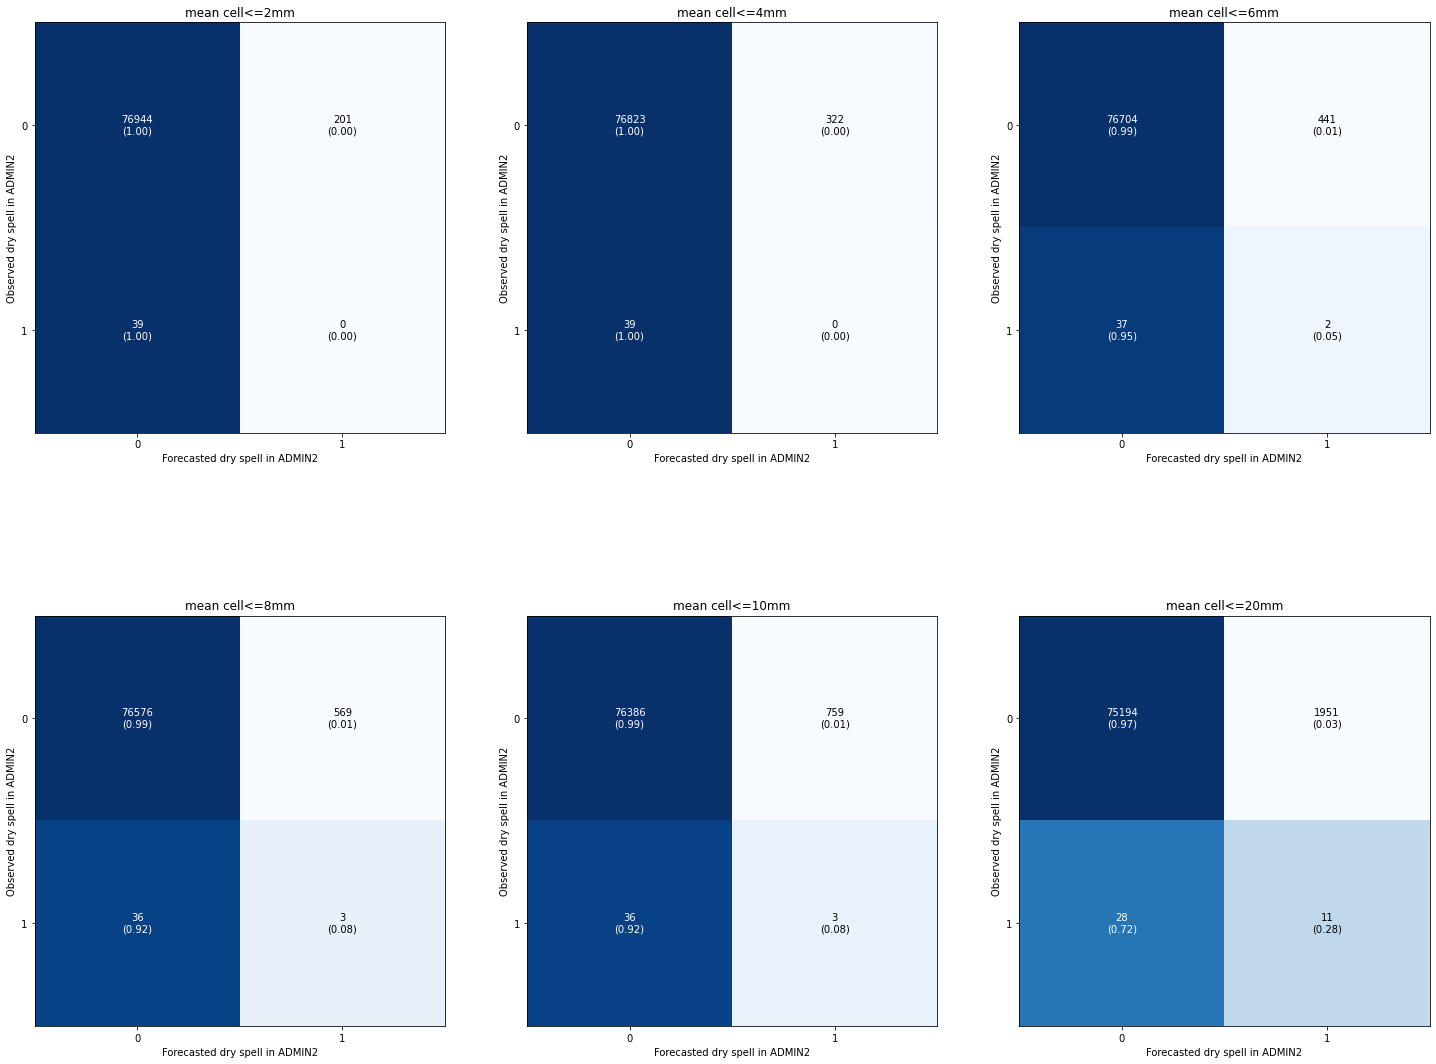

In [93]:
#compute the contigency table when using mean cell for different thresholds
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
t_list=[2,4,6,8,10,20]
num_plots = len(t_list)
colp_num=3
if num_plots==1:
    colp_num=1
rows = math.ceil(num_plots / colp_num)
position = range(1, num_plots + 1)
fig=plt.figure(figsize=(25,20))
for i,t in enumerate(t_list):
    y_target =    df_comb["dryspell_obs"]
    y_predicted = np.where(df_comb["mean_cell"]<=t,1,0)
    ax = fig.add_subplot(rows,colp_num,i+1)
    cm = confusion_matrix(y_target=y_target, 
                          y_predicted=y_predicted)

    plot_confusion_matrix(conf_mat=cm,show_absolute=True,show_normed=True,axis=ax) #,class_names=["No","Yes"])
    ax.set_ylabel("Observed dry spell in ADMIN2")
    ax.set_xlabel("Forecasted dry spell in ADMIN2")
    ax.set_title(f"mean cell<={t}mm")

In [94]:
#set definition of forecasted dry spell as max cell having not more than 2 mm of rains in 15 days period
df_comb["dryspell_forec"]=np.where(df_comb.mean_cell<=2,1,0)

#### correlation number of admin2s with observed and forecasted dry spell
Explore if correlation with number of adm2s experiencing a dry spell at a date.  
There is not.. 
This is again only about the start of the dry spell. Could explore the more loose definition of having any overlap between observed and forecasted, but not expecting much more correlation (correct me if I am wrong..)

In [95]:
#compute number of adm2s with dryspell per date
df_numadm=df_comb.groupby("date")[["dryspell_obs","dryspell_forec"]].sum()

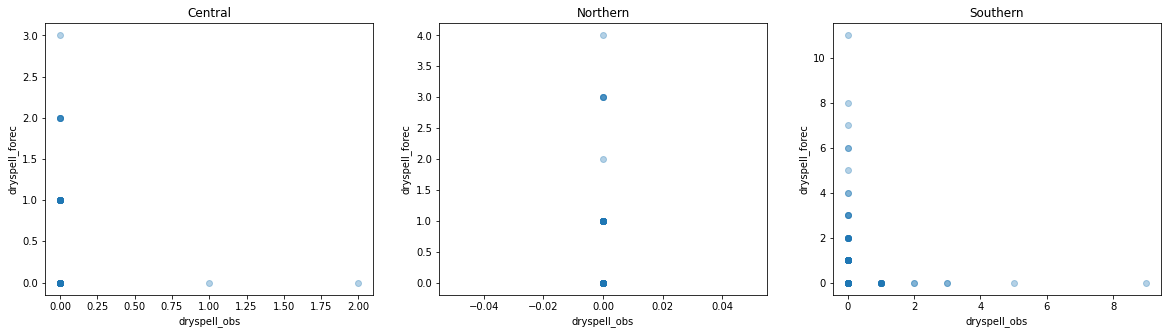

In [96]:
df_comb_adm1=df_comb.merge(df_bound_adm2[["ADM1_EN","ADM2_EN"]],on="ADM2_EN",how="left")
df_numadm1=df_comb_adm1.groupby(["date","ADM1_EN"],as_index=False)[["dryspell_obs","dryspell_forec"]].sum()

num_plots = len(df_numadm1.ADM1_EN.unique())
colp_num=3
if num_plots==1:
    colp_num=1
rows = math.ceil(num_plots / colp_num)
position = range(1, num_plots + 1)
fig=plt.figure(figsize=(20,5))


for i,a in enumerate(df_numadm1.ADM1_EN.unique()):
    ax = fig.add_subplot(rows,colp_num,i+1)
    g=sns.regplot(data = df_numadm1[df_numadm1.ADM1_EN==a], x = 'dryspell_obs', y = 'dryspell_forec', fit_reg = False,
            scatter_kws = {'alpha' : 1/3},ax=ax)#,x_jitter = 0.2, y_jitter = 0.2)
    g.axes.set_title(a)

### 5 day forecast

In [98]:
chirpsgefs_5day_path=os.path.join(chirpsgefs_processed_dir,"mwi_chirpsgefs_rainyseas_stats_mean_back_adm2_5day.csv")

In [99]:
#ccontains several statistics per adm2-date combination since 2000
df_cg_fd=pd.read_csv(chirpsgefs_5day_path)
df_cg_fd["date"]=pd.to_datetime(df_cg_fd["date"])
df_cg_fd["date_forec_end"]=pd.to_datetime(df_cg_fd["date_forec_end"])

In [100]:
df_bound_adm2=gpd.read_file(adm2_bound_path)

In [101]:
chirps_rolling_sum_path_5day=os.path.join(dry_spells_processed_dir,"data_mean_values_long_5day.csv")

In [102]:
#read historically observed 5 day rolling sum for all dates (so not only those with dry spells), derived from CHIRPS
#this sometimes gives a not permitted error --> move the chirps_rolling_sum_path file out of the folder and back in to get it to work (dont ask me why)
df_histobs=pd.read_csv(chirps_rolling_sum_path_5day)
df_histobs.date=pd.to_datetime(df_histobs.date)

#add start of the rolling sum 
df_histobs["date_start"]=df_histobs.date-timedelta(days=4)

#add adm2 and adm1 name
df_histobs=df_histobs.merge(df_bound_adm2[["ADM1_EN","ADM2_EN","ADM2_PCODE"]],left_on="pcode",right_on="ADM2_PCODE")

In [103]:
#merge forecast and observed
#only include dates that have a forecast, i.e. merge on right
#date in df_chirpsgefs is the first date of the forecast
#so the values are the rolling sum for the date+timedelta(t=days_ahead) #where days_aheas is 5 in this case
df_histformerg=df_histobs.merge(df_cg_fd,how="right",left_on=["date_start","ADM2_EN"],right_on=["date","ADM2_EN"],suffixes=("obs","forec"))

In [104]:
df_histformerg["diff_forecobs"]=df_histformerg["mean_cell"]-df_histformerg["rollsum_5d"]

In [105]:
#date_forec_end is not correct!! didn't adjust correctly in computation script
df_histformerg[["dateforec","dateobs","diff_forecobs","mean_cell","rollsum_5d","rollsum_15d"]]

,dateforec,dateobs,diff_forecobs,mean_cell,rollsum_5d,rollsum_15d
0,2000-01-01,2000-01-05,-4.113510,11.300500,15.41401,NaN
1,2000-01-02,2000-01-06,-6.926617,13.243983,20.17060,NaN
2,2000-01-03,2000-01-07,9.417646,20.851776,11.43413,NaN
3,2000-01-04,2000-01-08,6.726212,29.193962,22.46775,NaN
4,2000-01-05,2000-01-09,-29.647497,23.555213,53.20271,NaN
...,...,...,...,...,...,...
77563,2021-04-01,NaT,NaN,5.925734,NaN,NaN
77564,2021-04-02,NaT,NaN,6.100202,NaN,NaN
77565,2021-04-03,NaT,NaN,1.928683,NaN,NaN
77566,2021-04-04,NaT,NaN,7.851199,NaN,NaN


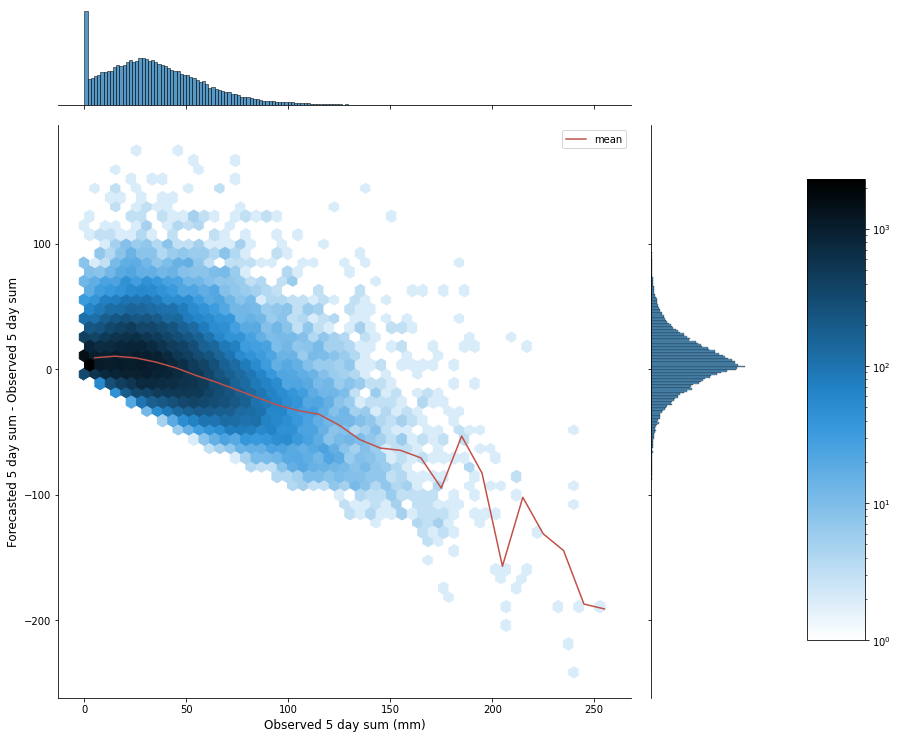

In [106]:
#plot the observed vs forecast-observed to get a feeling for the discrepancy between the two
g=sns.jointplot(data=df_histformerg,y="diff_forecobs",x="rollsum_5d", kind="hex",height=16,joint_kws={ 'bins':'log'})
#compute the average value of the difference between the forecasted and observed values
#do this in bins cause else very noisy mean
bins = np.arange(0,df_histformerg.rollsum_5d.max()+20,10)
group = df_histformerg.groupby(pd.cut(df_histformerg.rollsum_5d, bins))
plot_centers = (bins [:-1] + bins [1:])/2
plot_values = group.diff_forecobs.median()
g.ax_joint.plot(plot_centers,plot_values,color="#C25048",label="mean")
g.set_axis_labels("Observed 5 day sum (mm)", "Forecasted 5 day sum - Observed 5 day sum", fontsize=12)
plt.subplots_adjust(left=0.2, right=0.8, top=0.8, bottom=0.2)  # shrink fig so cbar is visible
# make new ax object for the cbar
cbar_ax = g.fig.add_axes([.85, .25, .05, .4])  # x, y, width, height
plt.colorbar(cax=cbar_ax)
g.ax_joint.legend()